In [ ]:
# pip install pandas-profiling[notebook]
# pip install imblearn

# Задача
Необходимо построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно будет определить значимые параметры заемщика.
Для каждого client_id в наборе тестов необходимо предсказать вероятность для default переменной. Файл должен содержать заголовок и иметь следующий формат:

client_id,default

66799,0.44100

25379, 0.13809174

где client_id - идентификатор заемщика, default - вероятность дефолта по кредиту.

Результаты оцениваются по площади под кривой ROC AUC

# **Подготовка**

In [1]:
import time
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import f_classif, mutual_info_classif, RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, OneSidedSelection

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Разместим в начале в одном блоке функции, с которыми будем работать по мере продвижения по проекту

In [130]:
def get_boxplot(column_x, column_y, orient=None, dframe=None):
    '''Построение боксплота для двух признаков. column_x - признак размещается
    по оси x, column_y - признак размещается по оси y, orient = "h"
    "кладет" боксплот набок. При этом, признаки меняются осями'''
    if dframe is None:
        dframe = data
    if orient is None or orient == 'v':
        fig, ax = plt.subplots(figsize=(dframe[column_x].nunique()*1.5, 5))
        sns.boxplot(x=column_x, y=column_y, data=dframe)
        plt.xticks(rotation=45)
        ax.set_title('Boxplot for ' + column_x)
        plt.show()
    elif orient == 'h':
        fig, ax = plt.subplots(figsize=(20, dframe[column_x].nunique()*0.7))
        sns.boxplot(x=column_y, y=column_x, data=dframe, orient='h')
        plt.xticks(rotation=45)
        ax.set_title('Boxplot for ' + column_y)
        plt.show()


'''Функция stats взята из моего проекта "project2 Анализ данных", во время 
работы над которым у меня не было информации о таком инструменте 
как pandas_profiling, в связи с чем, часть информации, выводимая функцией, 
дублирует информацию из отчета pandas_profiling'''


def stats(column, dframe=None):
    '''Описательная статистика и визуализация для числовых и категориальных данных'''
    if dframe is None:
        dframe = data
    if dframe[column].dtypes in ['int64', 'float64']:
        perc25 = dframe[column].quantile(0.25)
        column_median = dframe[column].median()
        column_mean = round(dframe[column].mean(), 4)
        perc75 = dframe[column].quantile(0.75)
        IQR = dframe[column].quantile(0.75) - dframe[column].quantile(0.25)
        IQR_val = dframe[column].loc[dframe[column].between(
            perc25, perc75)].count()
        IQR_val_percent = round(IQR_val/(dframe[column].count())*100, 2)
        min_point = perc25 - 1.5*IQR
        max_point = perc75 + 1.5*IQR
        stats_range = dframe[column].loc[dframe[column].between(
            min_point, max_point)].count()
        stats_range_percent = round(
            stats_range/(dframe[column].count())*100, 2)
        print()
        print('*'*138)
        print()
        print('Показатели для -= {} =-:'.format(column), '\n', '\n',
              'Общее количество значений (non-NA/null значений): {} ({})'.format(dframe.shape[0],
                                                                                 dframe[column].count()), '\n',
              # 'Уникальные значения: {}'.format(
              #    list(sorted(dframe[column].unique()))), '\n',
              'Минимум: {}'.format(min(dframe[column])), '\n',
              'Максимум: {}'.format(max(dframe[column])), '\n',
              'Мода: {}'.format(list(dframe[column].mode(dropna=False))), '\n',
              'Медиана: {}'.format(column_median), '\n',
              'Среднее: {}'.format(column_mean), '\n',
              'STD: {}'.format(round(dframe[column].std(), 4)), '\n',
              '25-й перцентиль: {}'.format(perc25), '\n',
              '75-й перцентиль: {}'.format(perc75), '\n',
              'IQR: {0}, кол-во значений: {1}, {2}%'.format(
                  IQR, IQR_val, IQR_val_percent), '\n',
              'Границы выбросов: [{0}, {1}], кол-во значений: {2}, {3}%'.format(min_point, max_point,
                                                                                stats_range,
                                                                                stats_range_percent), '\n',
              'Количество выбросов слева: ',
              dframe[column][dframe[column] < min_point].count(), '\n',
              'Количество выбросов справа: ',
              dframe[column][dframe[column] > max_point].count(), sep='')
        pd_object = pd.merge(dframe[column].value_counts(dropna=False).reset_index(),
                             (dframe[column].value_counts(
                                 normalize=True, dropna=False)*100)
                             .reset_index(), on='index')
        pd_object.columns = ['values', 'counts', '%']
        display(pd.DataFrame(pd_object))
        # dframe[column].hist()
        sns.set_theme(style="whitegrid")
        # sns.displot(x=column, bins=50, kde=True, data=dframe)
        plt.figure(figsize=(12,3))
        sns.kdeplot(data[column])
        # if stud[column].hasnans == False:
        fig = plt.figure()
        ax = fig.add_axes([0, 0, 1.7, 0.25])
        # ax1.boxplot(dframe[column][dframe[column].isna() == False],
        #            vert=False,flierprops=dict(markerfacecolor='r', marker='D'))
        sns.boxplot(x=column, data=dframe, ax=ax)
    else:
        print('Показатели для -= {} =-:'.format(column))
        display(pd.DataFrame(dframe[column].describe(include=all)))
        pd_object = pd.merge(dframe[column].value_counts(dropna=False).reset_index(),
                             (dframe[column].value_counts(
                                 normalize=True, dropna=False)*100)
                             .reset_index(), on='index')
        pd_object.columns = ['values', 'counts', '%']
        display(pd.DataFrame(pd_object))
        #dframe[column].value_counts().plot(kind = 'bar', grid = True)
        x_column = dframe[column][dframe[column].isna() == False]
        sns.set_theme(style="whitegrid")
        sns.histplot(x=x_column, bins=100, shrink=.4, data=dframe)


def lr_model(independent_features, target_feature, num_cols, not_normalize):
    '''Mодель логистической регрессии.'''
    data_train, data_val, target_train, target_val = train_test_split(independent_features,
                                                                      target_feature,
                                                                      test_size=0.20,
                                                                      random_state=42)
    # Нормализуем признаки
    if len(num_cols)!=0:
        scaler = QuantileTransformer(output_distribution='normal')
        data_train[:,:len(num_cols)] = scaler.fit_transform(data_train[:,:len(num_cols)])
        data_val[:,:len(num_cols)] = scaler.transform(data_val[:,:len(num_cols)])
    # Масштабируем все числовые признаки
    if len(num_cols+not_normalize)!=0:
        scaler = MinMaxScaler()
        scaler.fit(np.vstack([data_train[:,:len(num_cols+not_normalize)],
                              data_val[:,:len(num_cols+not_normalize)]]))
        data_train[:,:len(num_cols+not_normalize)] = scaler.transform(data_train[:,:len(num_cols+not_normalize)])
        data_val[:,:len(num_cols+not_normalize)] = scaler.transform(data_val[:,:len(num_cols+not_normalize)])
    # Обучаем модель на обучающей части
    model = LogisticRegression(random_state=42)
    model = model.fit(data_train, target_train)
    # Предсказываем целевую переменную на данных из валидационной части
    target_predicted = model.predict(data_val)
    target_predicted_prob = model.predict_proba(data_val)
    # Выводим получившиеся метрики
    print('accuracy_score:', accuracy_score(target_val, target_predicted))
    print('precision_score:', precision_score(target_val, target_predicted))
    print('recall_score:', recall_score(target_val, target_predicted))
    print('f1_score:', f1_score(target_val, target_predicted))
    сf_mtx = confusion_matrix(target_val, target_predicted)
    print()
    print('confusion matrix:', '\n', сf_mtx)
    tn, fp, fn, tp = сf_mtx.ravel()
    print()
    print('Предсказано невозращение кредита клиентом, по факту вернувшим кредит: {} \n\
    или {}% от всех вернувших \n'.format(fp, round((fp/(fp+tn))*100, 2)))
    print('Предсказан возврат кредита клиентом, по факту не вернувшим кредит: {} \n\
    или {}% от всех не вернувших\n'.format(fn, 
                                           round((1-recall_score(target_val,
                                                                 target_predicted))*100, 2)))
    print()
    print('roc_auc_score:', roc_auc_score(target_val, target_predicted_prob[:, 1]))
    fpr, tpr, threshold = roc_curve(target_val, target_predicted_prob[:, 1])
    roc_auc = roc_auc_score(target_val, target_predicted_prob[:, 1])
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    return model


def lr_featimp(num_cols, cat_cols, bin_cols, dframe=None):
    '''Оценка важности признаков для логистической модели'''
    if dframe is None:
        dframe = data
    if len(num_cols)!=0:
        print('Важность числовых признаков для модели')
        imp_num = pd.Series(f_classif(dframe[num_cols],dframe['default'])[0],
                            index=num_cols)
        imp_num.sort_values(inplace=True)
        imp_num.plot(kind='barh')
        plt.show()
    if len(cat_cols+bin_cols)!=0:
        print('Важность категориальных и бинарных признаков для модели')
        imp_cat = pd.Series(mutual_info_classif(dframe[cat_cols + bin_cols],
                                                dframe['default'],
                                                discrete_features=True),
                            index=cat_cols + bin_cols)
        imp_cat.sort_values(inplace=True)
        imp_cat.plot(kind='barh')


def rf_model(independent_features, target_feature, num_cols, not_normalize):
    '''Модель "случайный лес"'''
    data_train, data_val, target_train, target_val = train_test_split(independent_features,
                                                                      target_feature,
                                                                      test_size=0.20,
                                                                      random_state=42)
    # Нормализуем числовые признаки
    if len(num_cols) != 0:
        scaler = QuantileTransformer(output_distribution='normal')
        data_train[:,:len(num_cols)] = scaler.fit_transform(data_train[:,:len(num_cols)])
        data_val[:,:len(num_cols)] = scaler.transform(data_val[:,:len(num_cols)])
    # Масштабируем все числовые признаки
    if len(num_cols+not_normalize)!=0:
        scaler = MinMaxScaler()
        scaler.fit(np.vstack([data_train[:,:len(num_cols+not_normalize)],
                              data_val[:,:len(num_cols+not_normalize)]]))
        data_train[:,:len(num_cols+not_normalize)] = scaler.transform(data_train[:,:len(num_cols+not_normalize)])
        data_val[:,:len(num_cols+not_normalize)] = scaler.transform(data_val[:,:len(num_cols+not_normalize)])
    # Обучаем модель на обучающей части
    model = RandomForestClassifier(random_state=42)
    model = model.fit(data_train, target_train)
    # Предсказываем целевую переменную на данных из валидационной части
    target_predicted = model.predict(data_val)
    target_predicted_prob = model.predict_proba(data_val)
    # Выводим получившиеся метрики
    print('accuracy_score:', accuracy_score(target_val, target_predicted))
    print('precision_score:', precision_score(target_val, target_predicted))
    print('recall_score:', recall_score(target_val, target_predicted))
    print('f1_score:', f1_score(target_val, target_predicted))
    сf_mtx = confusion_matrix(target_val, target_predicted)
    print()
    print('confusion matrix:', '\n', сf_mtx)
    tn, fp, fn, tp = сf_mtx.ravel()
    print()
    print('Предсказано невозращение кредита клиентом, по факту вернувшим кредит: {} \n\
    или {}% от всех вернувших \n'.format(fp, round((fp/(fp+tn))*100, 2)))
    print('Предсказан возврат кредита клиентом, по факту не вернувшим кредит: {} \n\
    или {}% от всех не вернувших\n'.format(fn,
                                           round((1-recall_score(target_val,
                                                                 target_predicted))*100, 2)))
    print()
    print('roc_auc_score:', roc_auc_score(target_val, target_predicted_prob[:, 1]))
    fpr, tpr, threshold = roc_curve(target_val, target_predicted_prob[:, 1])
    roc_auc = roc_auc_score(target_val, target_predicted_prob[:, 1])
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Random Forest Classifier ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    return model


def rf_featimp(model,independent_features,dframe=None):
    '''Оценка важности признаков для "случайного леса" и "дерева решений"'''
    if dframe is None:
        dframe = data
    print('Важность признаков для модели')
    plt.figure(figsize=(5, 5))
    feat_importances = pd.Series(model.feature_importances_,
                                 index=independent_features)
    feat_importances.sort_values(inplace=True)
    feat_importances.plot(kind='barh')
    plt.show()


def dtc_model(independent_features, target_feature, num_cols, not_normalize):
    '''Модель "дерево решений"'''
    data_train, data_val, target_train, target_val = train_test_split(independent_features,
                                                                      target_feature,
                                                                      test_size=0.20,
                                                                      random_state=42)
    # Нормализуем числовые признаки
    if len(num_cols)!=0:
        scaler = QuantileTransformer(output_distribution='normal')
        data_train[:,:len(num_cols)] = scaler.fit_transform(data_train[:,:len(num_cols)])
        data_val[:,:len(num_cols)] = scaler.transform(data_val[:,:len(num_cols)])
    # Масштабируем все числовые признаки
    if len(num_cols+not_normalize)!=0:
        scaler = MinMaxScaler()
        scaler.fit(np.vstack([data_train[:,:len(num_cols+not_normalize)],
                              data_val[:,:len(num_cols+not_normalize)]]))
        data_train[:,:len(num_cols+not_normalize)] = scaler.transform(data_train[:,:len(num_cols+not_normalize)])
        data_val[:,:len(num_cols+not_normalize)] = scaler.transform(data_val[:,:len(num_cols+not_normalize)])    
    # Обучаем модель на обучающей части
    model = DecisionTreeClassifier(random_state=42)
    model = model.fit(data_train, target_train)
    # Предсказываем целевую переменную на данных из валидационной части
    target_predicted = model.predict(data_val)
    target_predicted_prob = model.predict_proba(data_val)
    # Выводим получившиеся метрики
    print('accuracy_score:', accuracy_score(target_val, target_predicted))
    print('precision_score:', precision_score(target_val, target_predicted))
    print('recall_score:', recall_score(target_val, target_predicted))
    print('f1_score:', f1_score(target_val, target_predicted))
    сf_mtx = confusion_matrix(target_val, target_predicted)
    print()
    print('confusion matrix:', '\n', сf_mtx)
    tn, fp, fn, tp = сf_mtx.ravel()
    print()
    print('Предсказано невозращение кредита клиентом, по факту вернувшим кредит: {} \n\
    или {}% от всех вернувших \n'.format(fp, round((fp/(fp+tn))*100, 2)))
    print('Предсказан возврат кредита клиентом, по факту не вернувшим кредит: {} \n\
    или {}% от всех не вернувших\n'.format(fn,
                                           round((1-recall_score(target_val,
                                                                 target_predicted))*100, 2)))
    print()
    print('roc_auc_score:', roc_auc_score(target_val, target_predicted_prob[:, 1]))
    fpr, tpr, threshold = roc_curve(target_val, target_predicted_prob[:, 1])
    roc_auc = roc_auc_score(target_val, target_predicted_prob[:, 1])
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Decision Tree Classifier ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    return model


def models_metrics(cols, num_cols, not_normalize, dframe=None):
    '''Обучение набора моделей и получение метрик'''
    if dframe is None:
        dframe = data
    learning_models, sampling_models, norm_models, lear, norm, sampl = params_of_models()
    norm_copy = norm.copy()
    sampl_copy = sampl.copy()
    independent_features = dframe[cols].values
    target_feature = dframe['default'].values
    data_metrics = pd.DataFrame(columns=['model', 'norm', 'sampl', 'precision',
                                         'recall', 'tn', 'fp', 'refuse_a_solvent,%',
                                         'tp', 'fn', 'approve_an_insolvent,%',
                                         'ras','accuracy'])
    # для каждой модели в соответствии со способами нормализации обучаем модели
    # на основе данных, полученных разными способами сэмплинга
    for learning_model in learning_models:
        for norm_model in norm_models:
            for sampling_model in sampling_models:
                models = [lear[0], norm[0], sampl[0]]
                models.extend(over_sampling(independent_features, target_feature,
                                            norm_model, sampling_model,
                                            learning_model, num_cols,not_normalize))
                data_temp = pd.DataFrame([models], columns=['model', 'norm', 'sampl',
                                                            'precision', 'recall',
                                                            'tn', 'fp',
                                                            'refuse_a_solvent,%',
                                                            'tp', 'fn',
                                                            'approve_an_insolvent,%',
                                                            'ras','accuracy'])
                data_metrics = pd.concat([data_metrics, data_temp],
                                         ignore_index=True)
                sampl.pop(0)
            sampl = sampl_copy.copy()
            norm.pop(0)
        norm = norm_copy.copy()
        lear.pop(0)
    return data_metrics


def params_of_models():
    '''Задание параметров для процесса обучения'''
    # Модели
    l_lr = LogisticRegression(random_state=42)
    l_rfc = RandomForestClassifier(random_state=42)
    learning_models = [l_lr, l_rfc]
    # Семплинг
    s_smote = SMOTE(random_state=42)
    s_adasyn = ADASYN(random_state=42)
    s_rus = RandomUnderSampler(random_state=42)
    s_nmiss = NearMiss()
    sampling_models = [s_smote, s_adasyn, s_rus, s_nmiss]
    # Нормализация данных
    n_qt = QuantileTransformer(output_distribution='normal')
    n_pt = PowerTransformer()
    norm_models = [n_qt, n_pt]
    lear = ['l_lr', 'l_rfc']
    norm = ['n_qt', 'n_pt']
    sampl = ['s_smote', 's_adasyn', 's_rus', 's_nmiss']
    return learning_models, sampling_models, norm_models, lear, norm, sampl


def over_sampling(independent_features, target_feature, norm_model, sampling_model,
                  learning_model, num_cols, not_normalize, return_model=None):
    '''Процесс обучения модели и получения метрики. Для возврата обученной
    модели параметр return_model = "return_model"'''
    # Разбиваем датасет на обучающую и валидационную части
    data_train, data_val, target_train, target_val = train_test_split(independent_features,
                                                                      target_feature,
                                                                      test_size=0.20,
                                                                      random_state=42)
    # Нормализуем числовые признаки
    if len(num_cols)!=0:
        scaler = norm_model
        data_train[:,:len(num_cols)] = scaler.fit_transform(data_train[:,:len(num_cols)])
        data_val[:,:len(num_cols)] = scaler.transform(data_val[:,:len(num_cols)])
    # Масштабируем все числовые признаки
    if len(num_cols+not_normalize)!=0:
        scaler_all = MinMaxScaler()
        scaler_all.fit(np.vstack([data_train[:,:len(num_cols+not_normalize)],
                                  data_val[:,:len(num_cols+not_normalize)]]))
        data_train[:,:len(num_cols+not_normalize)] = scaler_all.transform(data_train[:,:len(num_cols+not_normalize)])
        data_val[:,:len(num_cols+not_normalize)] = scaler_all.transform(data_val[:,:len(num_cols+not_normalize)])
    # Убираем дисбаланс целевой переменной в обучающей части
    data_train, target_train = sampling_model.fit_resample(data_train, target_train)
    # Обучаем модель на обучающей части
    model = learning_model.fit(data_train, target_train)
    # Предсказываем целевую переменную на данных из валидационной части
    target_predicted = model.predict(data_val)
    target_predicted_prob = model.predict_proba(data_val)
    # Сравниваем предсказание с фактом и оцениваем
    accuracy = accuracy_score(target_val, target_predicted)
    precision = precision_score(target_val, target_predicted)
    recall = recall_score(target_val, target_predicted)
    сf_mtx = confusion_matrix(target_val, target_predicted)
    tn, fp, fn, tp = сf_mtx.ravel()
    # процент клиентов, фактически вернувших кредит, но помеченных моделью как не вернувшие - ложная 1
    # от всего количества фактически вернувших = fp/(fp+tn). 
    # Показывает сколько "хороших" клиентов не получат кредит согласно прогнозу модели
    refuse_a_solvent = round((fp/(fp+tn))*100, 2)
    # % клиентов, фактически не вернувших кредит, но помеченных моделью как вернувшие - ложный 0, 
    # от всего количества фактически не вернувших кредит =  fn/(fn+tp) или 1-recall
    # Показывает сколько "плохих" клиентов получат редит согласно прогнозу модели
    approve_an_insolvent = round((1-recall)*100, 2)
    ras = roc_auc_score(target_val, target_predicted_prob[:, 1])
    if return_model is None:
        return precision, recall, tn, fp, refuse_a_solvent, tp, fn, approve_an_insolvent, ras, accuracy
    else:
        return model, scaler, scaler_all


def report_models(model, data_metrics):
    '''Представление метрик моделей в табличном виде'''
    models_dist = {'l_lr': 'LogisticRegression',
                   'l_rfc': 'RandomForestClassifier'}
    print('='*138,'\n')
    print('Отчет для {}: Oversampling'.format(models_dist[model]))
    display(data_metrics[(data_metrics.model == model) & (data_metrics.sampl.isin(
        ['s_smote', 's_adasyn']))].sort_values(by=['model', 'sampl', 'norm']))
    print()
    print('Отчет для {}: Undersampling'.format(models_dist[model]))
    display(data_metrics[(data_metrics.model == model) & (data_metrics.sampl.isin(
        ['s_rus', 's_nmiss']))].sort_values(by=['model', 'sampl', 'norm']))
    print('Отчет для {}: показатели Min Max'.format(models_dist[model]))
    print()
    display(data_metrics[data_metrics.model == model].sort_values(
        by=['model', 'sampl', 'norm']).agg([min, max]))
    print()


def feature_selection(independent_features, target_feature, norm_model,
                      sampling_model, learning_model, num_cols, not_normalize,
                      n_feat):
    '''Поиск наиболее важных признаков для модели'''
    # Разбиваем датасет на обучающую и валидационную части
    data_train, data_val, target_train, target_val = train_test_split(independent_features,
                                                                      target_feature,
                                                                      test_size=0.20,
                                                                      random_state=42)
    # Нормализуем числовые признаки
    if len(num_cols)!=0:
        scaler = norm_model
        data_train[:,:len(num_cols)] = scaler.fit_transform(data_train[:,:len(num_cols)])
        data_val[:,:len(num_cols)] = scaler.transform(data_val[:,:len(num_cols)])
    # Масштабируем все числовые признаки
    if len(num_cols+not_normalize)!=0:
        scaler = MinMaxScaler()
        scaler.fit(np.vstack([data_train[:,:len(num_cols+not_normalize)],
                              data_val[:,:len(num_cols+not_normalize)]]))
        data_train[:,:len(num_cols+not_normalize)] = scaler.transform(data_train[:,:len(num_cols+not_normalize)])
    # Убираем дисбаланс целевой переменной в обучающей части
    data_train, target_train = sampling_model.fit_resample(data_train, target_train)
    # Ищем наиболее важные признаки
    model = learning_model
    rfe = RFE(model, n_feat)
    rfe = rfe.fit(data_train, target_train)
    return rfe


def grid_params(independent_features, target_feature, norm_model, sampling_model,
                learning_model, num_cols, not_normalize, param_grid,grid):
    '''Поиск наиболее подходящих параметров для модели'''
    # Разбиваем датасет на обучающую и валидационную части
    data_train, data_val, target_train, target_val = train_test_split(independent_features,
                                                                      target_feature,
                                                                      test_size=0.20,
                                                                      random_state=42)
    # Нормализуем числовые признаки
    if len(num_cols)!=0:
        scaler = norm_model
        data_train[:,:len(num_cols)] = scaler.fit_transform(data_train[:,:len(num_cols)])
        data_val[:,:len(num_cols)] = scaler.transform(data_val[:,:len(num_cols)])
    # Масштабируем все числовые признаки
    if len(num_cols+not_normalize)!=0:
        scaler = MinMaxScaler()
        scaler.fit(np.vstack([data_train[:,:len(num_cols+not_normalize)],
                              data_val[:,:len(num_cols+not_normalize)]]))
        data_train[:,:len(num_cols+not_normalize)] = scaler.transform(data_train[:,:len(num_cols+not_normalize)])
    # Убираем дисбаланс целевой переменной в обучающей части
    data_train, target_train = sampling_model.fit_resample(data_train, target_train)
    model = learning_model
    if grid == 'grid':
        # Создание объекта GridSearchCV
        model_gs = GridSearchCV(model, param_grid, cv = 5)
        model_gs.fit(data_train, target_train)
        # Печать настроенных параметров и оценка
        print("Tuned Logistic Regression Parameters: {}".format(model_gs.best_params_))
        print("Best score is {}".format(model_gs.best_score_))
    elif grid == 'random':
        # Создание объекта RandomizedSearchCV
        model_rs = RandomizedSearchCV(model, param_grid,n_iter=100, 
                               cv=5, verbose=2, random_state=42, n_jobs=-1)
        model_rs.fit(data_train, target_train)
        # Печать настроенных параметров и оценка
        print("Tuned Random Forest Classifier Parameters: {}".format(model_rs.best_params_))
        print("Best score is {}".format(model_rs.best_score_))


def modify_dataset(dframe=None):
    '''Применение всех модификаций обучающего датасета к иным датасетам'''
    if dframe is None:
        dframe = data
    dframe.app_date = pd.to_datetime(dframe.app_date)
    #dframe.drop(['client_id'], axis=1, inplace=True)
    ed_mode = dframe.education.mode()[0]
    dframe.education.fillna(ed_mode, inplace=True)
    ed_dict = {'SCH': 0, 'UGR': 1, 'GRD': 2, 'PGR': 4, 'ACD': 5}
    dframe.education = dframe.education.replace(ed_dict)
    bin_cols = ['car', 'car_type', 'good_work', 'foreign_passport']
    label_encoder = LabelEncoder()
    for column in bin_cols:
        dframe[column] = label_encoder.fit_transform(dframe[column])
    dframe = pd.get_dummies(dframe, columns=['sex'])
    dframe['car_type_new'] = dframe[['car', 'car_type']].apply(
        lambda x: -1 if x[0] == x[1] == 0 else x[1], axis=1)
    dframe['car_type_new'] = dframe['car_type_new'].replace({-1: 'no_car',
                                                             0: 'd_car',
                                                             1: 'f_car'})
    dframe = pd.concat([dframe,pd.get_dummies(dframe.car_type_new)],axis=1)
    dframe['day_of_month'] = dframe.app_date.dt.day
    dframe['day_of_week'] = dframe.app_date.dt.dayofweek
    dframe.drop(['app_date'], axis=1, inplace=True)
    def func(x):
        if x<31:
            return 0
        elif x<41:
            return 1
        elif x<56:
            return 2
        else:
            return 3
    dframe['age_cat'] = dframe.age.apply(func)
    region_dict = {i:int(i/10) for i in range(0,110,10)}
    dframe['region_rating_cat'] = dframe['region_rating'].replace(region_dict)
    dframe['day_of_month_cat'] = dframe.day_of_month.apply(lambda x: 1 
                                                           if x in range(1, 11) 
                                                           else 2 if x in range(11, 21)
                                                           else 3)
    dframe['day_of_week_cat'] = dframe.day_of_week.apply(lambda x: 0
                                                         if x in [5,6] else 1)
    def income_cat(x):
        if x <= 21000:
            x = 0
        elif x <= 31000:
            x = 1
        elif x <= 50000:
            x = 2
        elif x <=101000:
            x = 3
        else:
            x = 4
        return x
    dframe['income_cat'] = dframe.income.apply(income_cat)
    income_dict = {}
    for value in dframe.region_rating.unique():
        value_part = dframe.income[dframe.region_rating==value]
        max_point = value_part.quantile(0.75) + 1.5*(value_part.quantile(0.75)-value_part.quantile(0.25))
        income_dict[value] = max_point
    dframe['income_rating'] = dframe[['region_rating','income']].apply(lambda x:
                                                                       x[1]/income_dict[x[0]],
                                                                       axis=1)
    poly = PolynomialFeatures(2)
    dframe['decline_app_cnt_temp'] = dframe['decline_app_cnt']+1
    dframe['bki_request_cnt_temp'] = dframe['bki_request_cnt']+1
    poly = poly.fit_transform(dframe[['decline_app_cnt_temp','bki_request_cnt_temp',
                                      'score_bki','age','income_rating']])
    poly = pd.DataFrame(poly,columns=['poly_'+str(i+1) for i in range(poly.shape[1])])
    dframe = pd.concat([dframe,poly],axis=1)
    dframe['decline_app_cnt_temp'] = dframe['decline_app_cnt'].apply(lambda x:
                                                                     x if x == 0
                                                                     else 1)
    dframe = pd.concat([dframe,
                        pd.get_dummies(dframe.decline_app_cnt_temp,
                                       prefix='decline_app_cnt')],
                       axis=1)
    dframe['bki_request_cnt_temp'] = dframe['bki_request_cnt'].apply(lambda x:
                                                                     x if x == 0
                                                                     else 1)
    dframe = pd.concat([dframe,
                        pd.get_dummies(dframe.bki_request_cnt_temp,
                                       prefix='bki_request_cnt')],
                       axis=1)
    dframe.drop(columns=['decline_app_cnt_temp','bki_request_cnt_temp'],
                inplace=True)
    return dframe

# **Предварительный анализ данных и работа с базовой моделью**

In [3]:
data = pd.read_csv('train.csv')
data.head()

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   
2      25887  01FEB2014       SCH   M   25   Y        N                2   
3      16222  23JAN2014       SCH   F   53   N        N                0   
4     101655  18APR2014       GRD   M   48   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0    -2.0088                1             50             1   
1          0    -1.5323                3             50             2   
2          0    -1.4081                1             80             1   
3          0    -2.0575                2             50             2   
4          1    -1.2447                1             60             2   

   work_address  income  sna  first_time foreign_passport  default  
0             2   18000    4           1                N        0  
1             3   19000    4           1                N        0  
2             2   30000    1           4                Y        0  
3             3   10000    1           3                N        0  
4             3   30000    1           4                Y        0

Для сохранения результатов работы с признаками для дальнейшего их применения к другим датасетам, создана соответствующая функцию (в блоке с функциями) - modify_dataset, которая была сформирована по мере продвижения работы над проектом

In [4]:
data.app_date = pd.to_datetime(data.app_date)

Для получения статистики по признакам воспользуемся модулем **pandas_profiling**

In [ ]:
profile_report = ProfileReport(data, title='Train report')
profile_report

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Признаки датасета**

|№           | Признак                    | Значение          | Тип признака 
|----------- |:--------------------------|:-----------------|:-----------------|
|1.          |client_id                  |id клиента|Числовой
|2.          |education                   |уровень образования|Категориальный
|3.          |      sex                   |       пол заёмщика|Категориальный
|4.          |      age                   |   возраст заёмщика|Числовой
|5.          |      car               |флаг наличия автомобиля|Бинарный
|6.          | car_type              |флаг автомобиля-иномарки|Бинарный
|7.    |decline_app_cnt  |количество отказанных прошлых заявок|Числовой
|8.          |good_work         |флаг наличия «хорошей» работы|Бинарный
|9.    |bki_request_cnt             |количество запросов в БКИ|Числовой
|10.       |home_address        |категоризатор домашнего адреса|Категориальный
|11.       |work_address         |категоризатор рабочего адреса|Категориальный
|12.            |income                        |доход заёмщика|Числовой
|13.  |foreign_passport                |наличие загранпаспорта|Бинарный
| 14. |sna |связь заемщика с клиентами банка|Категориальный
|15. |first_time |давность наличия информации о заемщике|Категориальный
|16. |score_bki |скоринговый балл по данным из БКИ|Числовой
|17. |region_rating |рейтинг региона|Числовой (Категориальный)
|18. |app_date |дата подачи заявки|Временной
|19.           |default                       |наличие дефолта (ЦЕЛЕВОЙ ПРИЗНАК)|Бинарный

Итак, мы видим, что датасет содержит:
- 7 числовых
- 6 категориальных
- 5 бинарных
- 1 временной признак.

**Целевая переменная - default**.

Признак **client_id** имеет равномерное распределение, содержит только уникальные значения и сами по себе идентификационные номера клиентов не могут оказывать влияние на поведение и финансовые возможности клиента по исполнению им обязательтсв по кредитному договору. Таким образом, удалим данный признак из датасета.

In [5]:
data.drop(['client_id'], axis=1, inplace=True)


Распределим признаки по группам

In [6]:
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt',
           'income', 'score_bki', 'region_rating']
cat_cols = ['education', 'sex', 'home_address',
           'work_address', 'sna', 'first_time']
bin_cols = ['car', 'car_type', 'good_work', 'foreign_passport']
#  + временной признак app_date

**education** Согласно информации из отчета, у нас имеются пропуски в датасете только в столбце education, что составляет 0.41% от всех данных столбца. Заполнить пропуски можно было бы попробовать с помощью наивного байесовского классификатора / from sklearn.naive_bayes import MultinomialNB / (в качестве тренировки так и поступил на данных с платформы SF). Но ввиду мало количества пропусков проще заполнить строки модой.

In [7]:
ed_mode = data.education.mode()[0]
data.education.fillna(ed_mode, inplace=True)

Исходя из аббревиатур в данном столбце, признак указывает на ступени образования (возможно США, но это не точно). 

А именно:
- SCH (school) школьное образование
- UGR (undergraduate) базовое высшее с получением степени бакалавра
- GRD (graduate) базовое высшее с получением степени магистра
- PGR (postgraduate) профессиональная специализация
- ACD (academic degree)

Учитывая, что данные ранжированы, заменим их на числовые значения с соблюдением градации

In [8]:
ed_dict = {'SCH': 0, 'UGR': 1, 'GRD': 2, 'PGR': 4, 'ACD': 5}
data.education = data.education.replace(ed_dict)

Для **бинарных** признаков воспользуемся методом кодирования - LabelEncoder (good_work уже так закодирован)

In [9]:
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

Признак **sex** закодируем с помощью One-Hot Encoding для того, чтобы не вносить ранжирование в данные. После удалим признак из числовых столбцов и добавим два признака в бинарные.

In [10]:
data = pd.get_dummies(data, columns=['sex'])
cat_cols.remove('sex')
bin_cols.extend(['sex_F','sex_M'])

Согласно отчету, признаки **car** и **car_type** имеют высокую корреляцию. При этом, на мой взгляд, в столбце car_type, в котором данные делятся на иностранный автомобиль и отечественный, в случае, если в столбце car присутствует 0, т.е. клиент не владеет автомобилем, указаны некорректные данные, а именно - 0, что означает отечественный автомобиль. Но при отсутствии у клиента автомобиля, в столбце car_type не может быть значений, характеризующих автомобиль. Таким образом для начала, все значения в столбце car_type для клиентов, у которых автомобиля нет заменим на -1, после разделим car_type на вспомогательные признаки: владение отечественным (domestic - d_car) авто, владение иностранным (foregin - f_car) авто и отсутствие автомобиля в собственности (no_car)

In [11]:
data['car_type_new'] = data[['car', 'car_type']].apply(
    lambda x: -1 if x[0] == x[1] == 0 else x[1], axis=1)
data['car_type_new'] = data['car_type_new'].replace({-1: 'no_car', 0: 'd_car', 1: 'f_car'})
data = pd.concat([data,pd.get_dummies(data.car_type_new)],axis=1)
bin_cols.remove('car')
bin_cols.remove('car_type')
bin_cols.extend(['d_car', 'f_car','no_car'])


Временной признак датасета **app_date** содержит сведения только за январь-апрель 2014 года, т.е. достаточно ограниченный период. Поэтому возьмем из этого признака день недели и день месяца, а сам признак удалим. 

In [12]:
data['day_of_month'] = data.app_date.dt.day
data['day_of_week'] = data.app_date.dt.dayofweek
data.drop(['app_date'], axis=1, inplace=True)
num_cols.extend(['day_of_week','day_of_month'])

Затрудняюсь отнести новые данные к категориальным или числовым. Пока можно оставить так как есть (числовые признаки) и посмотреть, как справится модель. Затем можно дни недели заменить на две категории: рабочие дни и выходные (видно, что в рабочие дни активнее подаются заявки), а дни месяца разделить на декады.

**Целевая переменная**


******************************************************************************************************************************************

Показатели для -= default =-:

Общее количество значений (non-NA/null значений): 73799 (73799)
Минимум: 0
Максимум: 1
Мода: [0]
Медиана: 0.0
Среднее: 0.127
STD: 0.333
25-й перцентиль: 0.0
75-й перцентиль: 0.0
IQR: 0.0, кол-во значений: 64427, 87.3%
Границы выбросов: [0.0, 0.0], кол-во значений: 64427, 87.3%
Количество выбросов слева: 0
Количество выбросов справа: 9372


values  counts       %
0       0   64427 87.3006
1       1    9372 12.6994

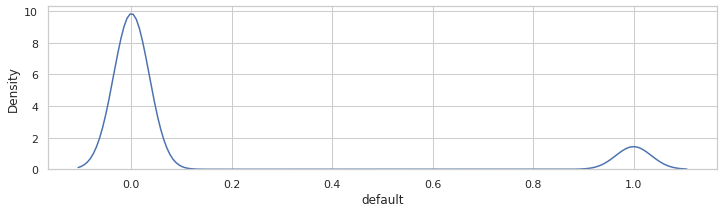

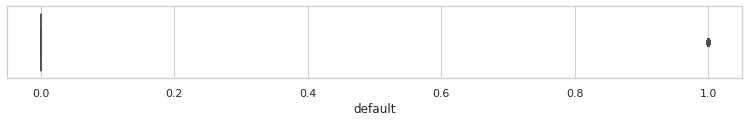

In [13]:
stats('default')

Видим, что целевая переменная не сбалансирована по классам и, возможно, в дальнейшем это придеться исправлять

Далее, посмотрим, какое значение могут иметь независимые признаки в текущем виде для модели **логистической регрессии** (одна из моделей, которая планируется к использованию для обучения). Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn. Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif.

In [14]:
print(num_cols)
print(cat_cols)
print(bin_cols)

['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating', 'day_of_week', 'day_of_month']
['education', 'home_address', 'work_address', 'sna', 'first_time']
['good_work', 'foreign_passport', 'sex_F', 'sex_M', 'd_car', 'f_car', 'no_car']


Важность числовых признаков для модели


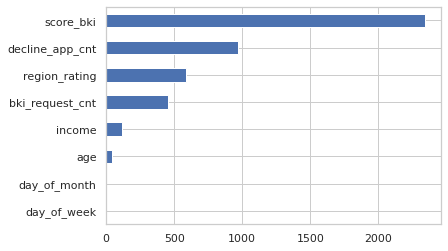

Важность категориальных и бинарных признаков для модели


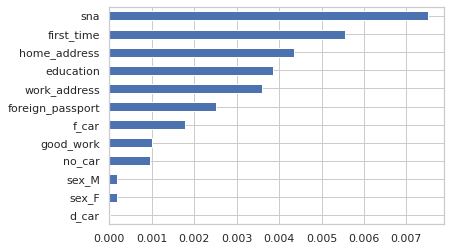

In [15]:
lr_featimp(num_cols,cat_cols,bin_cols)

Пока мы видим, что новые признаки имеют низкую значимость. При этом из имевшихся признаков, большее значение имеют информация и взаимодействие с БКИ, а также неизвестные пока связи заемщика  с клиентами банка, дата первого обращения, домашний адрес и образование. При этом достаточно важные в реальности признаки, такие как возраст и доход в данном датасете для логрегрессии имеют низкую значимость. Оставим пока признаки в данном виде и попробуем обучить модель на имеющихся сведениях.

In [16]:
independent_features = data[num_cols+cat_cols+bin_cols].values
target_feature = data['default'].values

In [17]:
not_normalize = [] # группа числовых признаков, не подлежащих нормализации. Будет использоваться далее

accuracy_score: 0.875609756097561
precision_score: 0.4383561643835616
recall_score: 0.01751505199781062
f1_score: 0.033684210526315796

confusion matrix: 
 [[12892    41]
 [ 1795    32]]

Предсказано невозращение кредита клиентом, по факту вернувшим кредит: 41 
    или 0.32% от всех вернувших 

Предсказан возврат кредита клиентом, по факту не вернувшим кредит: 1795 
    или 98.25% от всех не вернувших


roc_auc_score: 0.7373155682452669


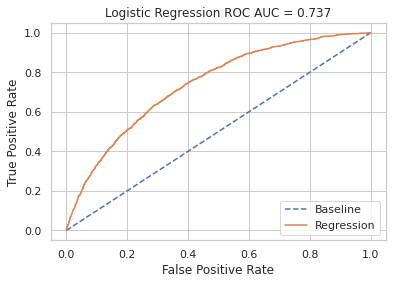

Важность числовых признаков для модели


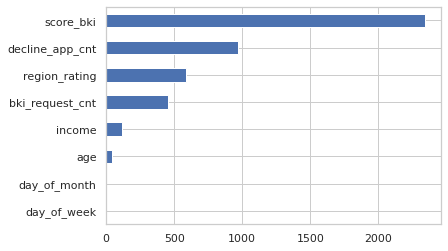

Важность категориальных и бинарных признаков для модели


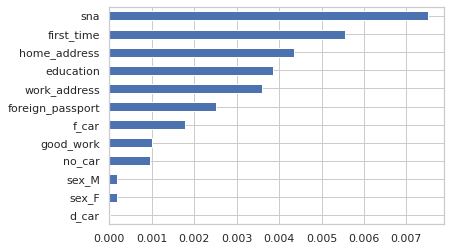

In [18]:
model_lr = lr_model(independent_features,target_feature,num_cols,not_normalize)
# coeff_df = pd.DataFrame(abs(model_lr.coef_),columns=[num_cols+cat_cols+bin_cols]).T
# coeff_df.columns = ['Features']
# coeff_df.sort_values(by='Features',inplace=True)
# coeff_df.plot(kind='barh')
# plt.legend(loc='lower right')
# plt.show()
lr_featimp(num_cols,cat_cols,bin_cols)

В целом, модель показывает неплохой результат - 87% правильных прогнозов, однако то, что 98% "плохих" клиентов его бы получили, представляется не очень хорошим прогнозом для банка.

Попробуем применить другую модель классификации - **"случайный лес"**

accuracy_score: 0.8745257452574525
precision_score: 0.34177215189873417
recall_score: 0.014778325123152709
f1_score: 0.02833158447009444

confusion matrix: 
 [[12881    52]
 [ 1800    27]]

Предсказано невозращение кредита клиентом, по факту вернувшим кредит: 52 
    или 0.4% от всех вернувших 

Предсказан возврат кредита клиентом, по факту не вернувшим кредит: 1800 
    или 98.52% от всех не вернувших


roc_auc_score: 0.7064986016305417


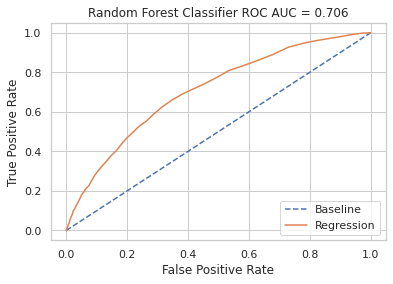

Важность признаков для модели


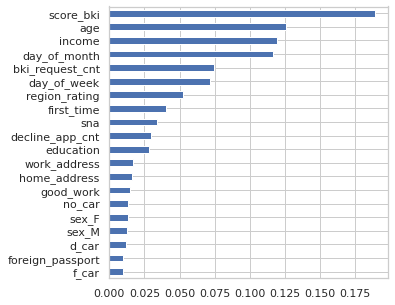

In [19]:
model_rf = rf_model(independent_features,target_feature,num_cols,not_normalize)
rf_featimp(model_rf,num_cols+cat_cols+bin_cols)

Результаты практически такие же (чуть лучше прогнозирует "хороших", чуть хуже "плохих"), что и на логистической регрессии, только значимые признаки уже более "реальные" - скорринг БКИ, возраст и доход

И посмотрим еще на одну модель - **"дерево решений"**

accuracy_score: 0.7861111111111111
precision_score: 0.19745222929936307
recall_score: 0.23754789272030652
f1_score: 0.21565217391304348

confusion matrix: 
 [[11169  1764]
 [ 1393   434]]

Предсказано невозращение кредита клиентом, по факту вернувшим кредит: 1764 
    или 13.64% от всех вернувших 

Предсказан возврат кредита клиентом, по факту не вернувшим кредит: 1393 
    или 76.25% от всех не вернувших


roc_auc_score: 0.5505763124005152


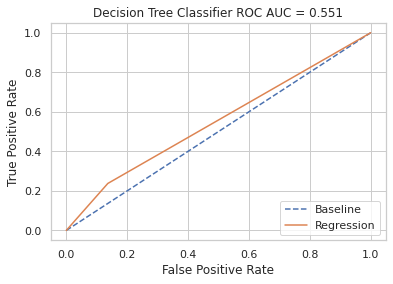

Важность признаков для модели


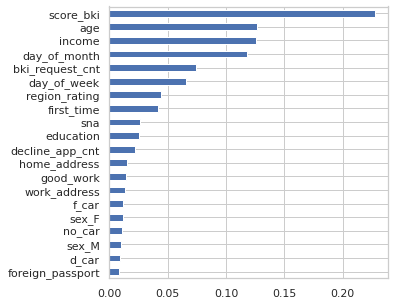

In [20]:
model_dtc = dtc_model(independent_features,target_feature,num_cols,not_normalize)
rf_featimp(model_dtc,num_cols+cat_cols+bin_cols)

Видим, что "плохие" клиенты начали распозноваться лучше, но при этом ухудшилась работа с "хорошими" и в целом предсказание модели близко к вероятности орла и решки при подбрасывании монетки. Данная модель показала худший результат. Думаю, в дальнейшем эту модель использовать не буду

Возможно из-за того, что зависимая переменная не сбалансирована - 87% данных принадлежит к одному классу, моделям проще практически каждый раз предсказывать именно этот класс, чтобы повысить свою точность. Но из представленных выше отчетов (ошибки 1  и 2 рода) всем моделям это не очень удается.

# **Обучение с сэмплингом. Попытка 1**

Посмотрим на распределение **числовых переменных**

AGE


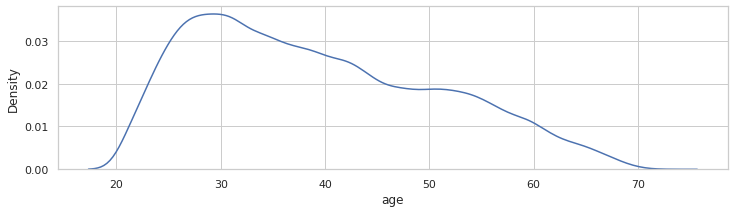

DECLINE_APP_CNT


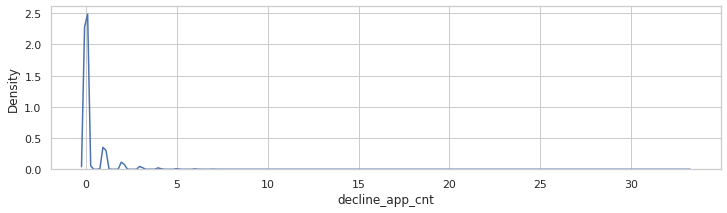

BKI_REQUEST_CNT


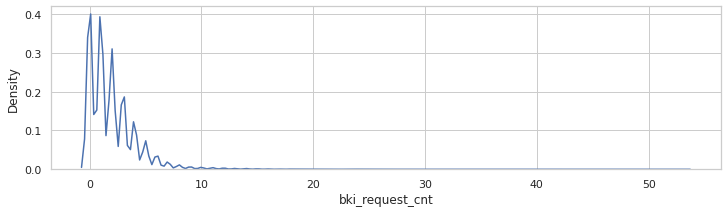

INCOME


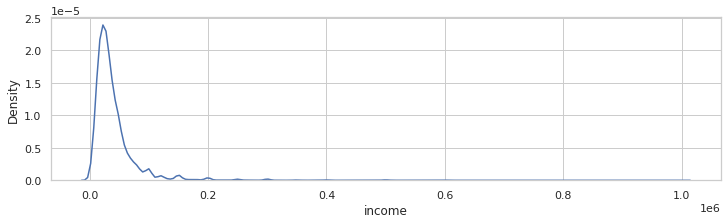

SCORE_BKI


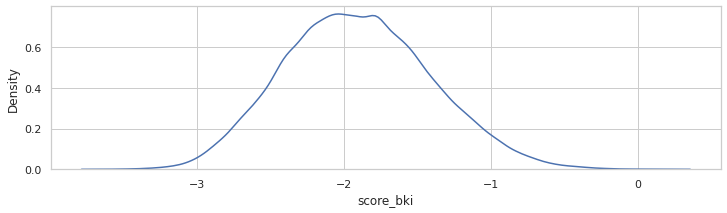

REGION_RATING


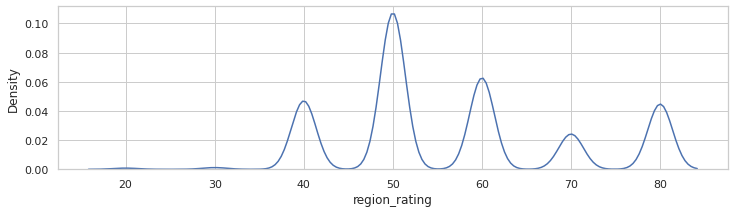

DAY_OF_WEEK


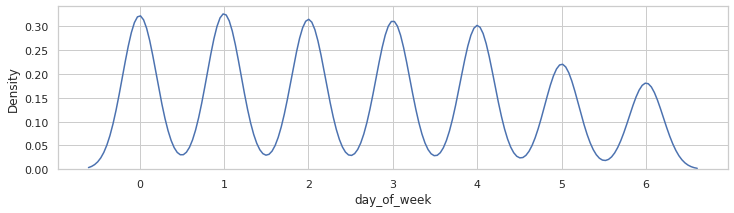

DAY_OF_MONTH


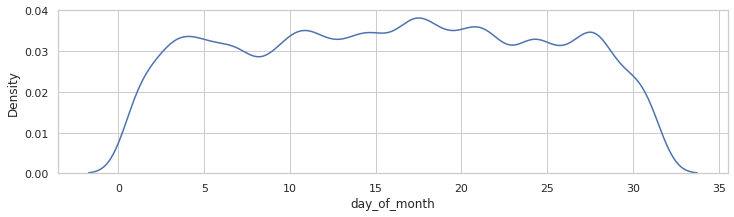

In [21]:
for column in num_cols:
    plt.figure(figsize=(12,3))
    print(column.upper())
    sns.kdeplot(data[column])
    plt.show()

Числовые признаки имеют смещение вправо, за исключением **region** (скорее всего это категориальный признак, нужно будет его перевести в cat_cols и перекодировать), временных и **score_bki**.

Обучение моделей производилось на стандартизированных числовых признакаx (с помощью StandardScaler). Посмотрим, как методы стандартизации работают с нашими признаками. Для примера возьмем количество отказов в выдаче кредитов **decline_app_cnt**, доход **income** и скорринговый балл БКИ **score_bki**. Применим к нашим данным
* StandardScaler
* RobustScaler
* QuantileTransformer
* PowerTransformer
* Логнормирование

DECLINE_APP_CNT  distribution



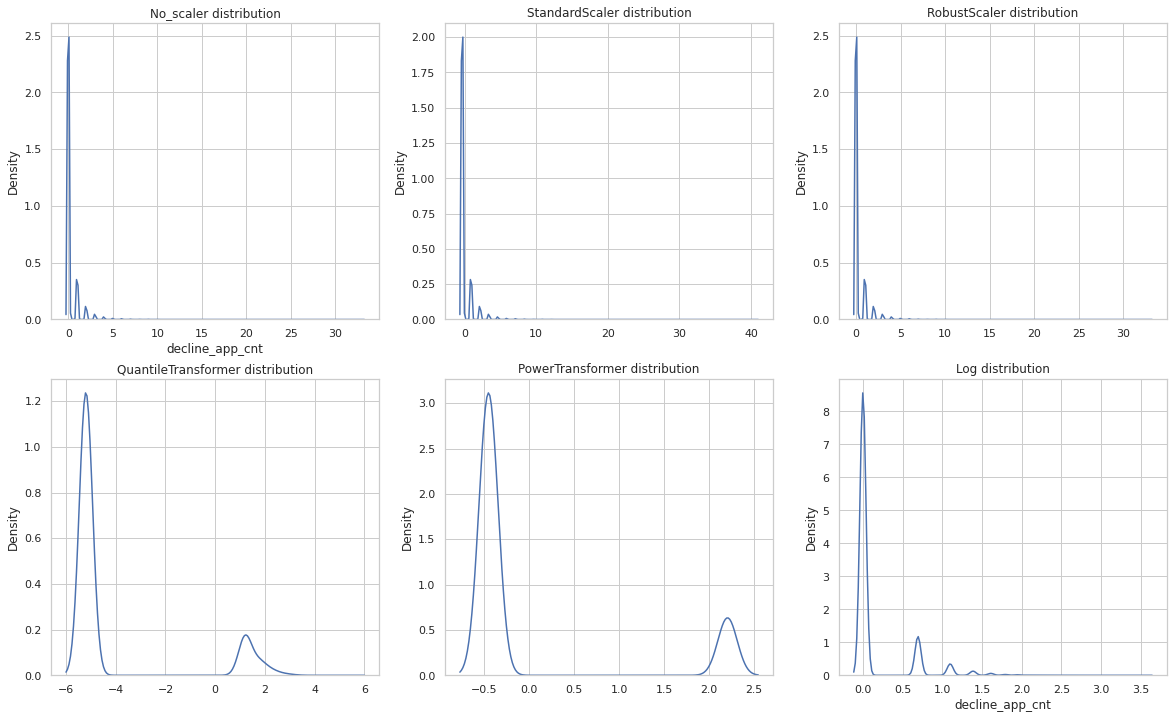

INCOME  distribution



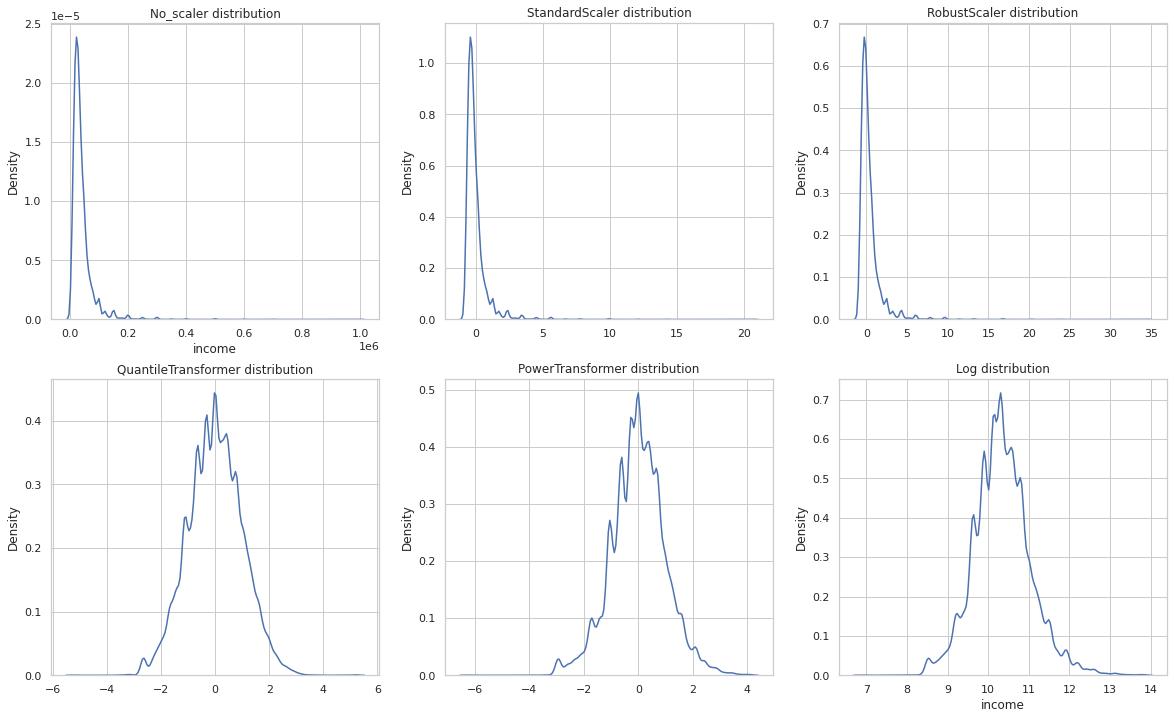

SCORE_BKI  distribution



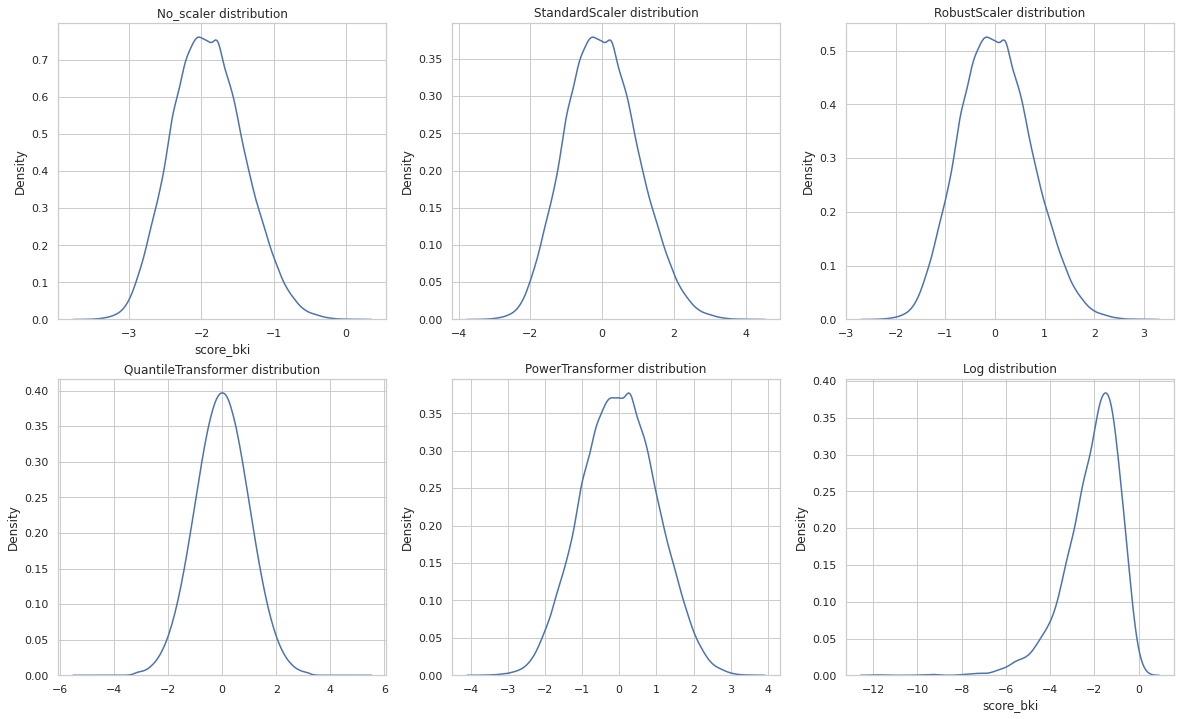

In [22]:
sc = StandardScaler()
rs = RobustScaler()
qt = QuantileTransformer(output_distribution='normal')
pt = PowerTransformer()
for feature in ['decline_app_cnt','income','score_bki']:
    _, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,12))
    ax[0][0].set_title("No_scaler distribution")
    ax[0][1].set_title("StandardScaler distribution")
    ax[0][2].set_title("RobustScaler distribution")
    ax[1][0].set_title("QuantileTransformer distribution")
    ax[1][1].set_title("PowerTransformer distribution")
    ax[1][2].set_title("Log distribution")
    print('='*138)
    print(feature.upper(),' distribution')
    print()
    sns.kdeplot(data[feature], ax=ax[0][0])
    sns.kdeplot(sc.fit_transform(data[feature].values.reshape(-1, 1)).flatten(), ax=ax[0][1])
    sns.kdeplot(rs.fit_transform(data[feature].values.reshape(-1, 1)).flatten(), ax=ax[0][2])
    sns.kdeplot(qt.fit_transform(data[feature].values.reshape(-1, 1)).flatten(), ax=ax[1][0])
    sns.kdeplot(pt.fit_transform(data[feature].values.reshape(-1, 1)).flatten(), ax=ax[1][1])
    sns.kdeplot(np.log(data[feature]+1), ax=ax[1][2])
    plt.show()


_QuantileTransformer_ и _PowerTransformer_ оказывают наилучшее влияние на нормализацию данных. При этом стоит заметить, что **score_bki** изначально имеет распределение похожее на нормальное. Скорее всего, в БКИ сведения проходили предварительную обработку. Думаю, что нет смысла повторно их нормировать


In [23]:
num_cols.remove('score_bki')
not_normalize = ['score_bki']

Для выравнивания дисбаланса целевой переменной применим методы Oversampling (добавление элементов в класс меньшинства (1) путем искусственного создания дополнительных наблюдениий, необходимых, чтобы сравняться с мажоритарным классом (0) по количеству наблюдений) и UnderSampling (удаление наблюдений из мажоритарного класса до тех пор, пока он не сравняется по их количеству с миноритарным классом). 

Для Oversampling будем использовать алгоритмы:
- SMOTE,
- ADASYN.

Для UnderSampling:
- RandomUnderSampler,
- NearMiss

### Модели
|Код|Расшифровка| 
|:-|:-|
|l_lr|LogisticRegression|
|l_rfc|RandomForestClassifier|

### Семплинг
|Код|Расшифровка| 
|:-|:-|
|s_smote|SMOTE
|s_adasyn|ADASYN
|s_rus|RandomUnderSampler
|s_nmiss|NearMiss

### Нормализация данных
|Код|Расшифровка| 
|:-|:-|
|n_qt|QuantileTransformer
|n_pt|PowerTransformer

In [24]:
cols = num_cols+not_normalize+cat_cols+bin_cols
cols

['age',
 'decline_app_cnt',
 'bki_request_cnt',
 'income',
 'region_rating',
 'day_of_week',
 'day_of_month',
 'score_bki',
 'education',
 'home_address',
 'work_address',
 'sna',
 'first_time',
 'good_work',
 'foreign_passport',
 'sex_F',
 'sex_M',
 'd_car',
 'f_car',
 'no_car']

In [25]:
data_metrics = models_metrics(cols,num_cols,not_normalize)
for model in ['l_lr', 'l_rfc']:
    report_models(model, data_metrics)
display(data_metrics.agg([min,max]))


Отчет для LogisticRegression: Oversampling


model  norm     sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
5  l_lr  n_pt  s_adasyn     0.2180  0.6935  8389  4544             35.1300   
1  l_lr  n_qt  s_adasyn     0.2155  0.6853  8376  4557             35.2400   
4  l_lr  n_pt   s_smote     0.2221  0.6825  8565  4368             33.7700   
0  l_lr  n_qt   s_smote     0.2206  0.6776  8559  4374             33.8200   

     tp   fn  approve_an_insolvent,%    ras  accuracy  
5  1267  560                 30.6500 0.7347    0.6542  
1  1252  575                 31.4700 0.7344    0.6523  
4  1247  580                 31.7500 0.7362    0.6648  
0  1238  589                 32.2400 0.7355    0.6638


Отчет для LogisticRegression: Undersampling


model  norm    sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
7  l_lr  n_pt  s_nmiss     0.1301  0.6990  4395  8538             66.0200   
3  l_lr  n_qt  s_nmiss     0.1291  0.6798  4558  8375             64.7600   
6  l_lr  n_pt    s_rus     0.2231  0.6864  8567  4366             33.7600   
2  l_lr  n_qt    s_rus     0.2225  0.6902  8527  4406             34.0700   

     tp   fn  approve_an_insolvent,%    ras  accuracy  
7  1277  550                 30.1000 0.5160    0.3843  
3  1242  585                 32.0200 0.5143    0.3930  
6  1254  573                 31.3600 0.7378    0.6654  
2  1261  566                 30.9800 0.7377    0.6631

Отчет для LogisticRegression: показатели Min Max



model  norm     sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
min  l_lr  n_pt  s_adasyn     0.1291  0.6776  4395  4366             33.7600   
max  l_lr  n_qt   s_smote     0.2231  0.6990  8567  8538             66.0200   

       tp   fn  approve_an_insolvent,%    ras  accuracy  
min  1238  550                 30.1000 0.5143    0.3843  
max  1277  589                 32.2400 0.7378    0.6654



Отчет для RandomForestClassifier: Oversampling


model  norm     sampl  precision  recall     tn   fp  refuse_a_solvent,%  \
13  l_rfc  n_pt  s_adasyn     0.3163  0.0777  12626  307              2.3700   
9   l_rfc  n_qt  s_adasyn     0.3229  0.0788  12631  302              2.3400   
12  l_rfc  n_pt   s_smote     0.3340  0.0865  12618  315              2.4400   
8   l_rfc  n_qt   s_smote     0.3430  0.0909  12615  318              2.4600   

     tp    fn  approve_an_insolvent,%    ras  accuracy  
13  142  1685                 92.2300 0.7060    0.8650  
9   144  1683                 92.1200 0.7085    0.8655  
12  158  1669                 91.3500 0.7089    0.8656  
8   166  1661                 90.9100 0.7109    0.8659


Отчет для RandomForestClassifier: Undersampling


model  norm    sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
15  l_rfc  n_pt  s_nmiss     0.1255  0.7581  3282  9651             74.6200   
11  l_rfc  n_qt  s_nmiss     0.1255  0.7657  3186  9747             75.3700   
14  l_rfc  n_pt    s_rus     0.2068  0.6656  8268  4665             36.0700   
10  l_rfc  n_qt    s_rus     0.2076  0.6678  8277  4656             36.0000   

      tp   fn  approve_an_insolvent,%    ras  accuracy  
15  1385  442                 24.1900 0.5069    0.3162  
11  1399  428                 23.4300 0.4994    0.3106  
14  1216  611                 33.4400 0.7148    0.6425  
10  1220  607                 33.2200 0.7146    0.6434

Отчет для RandomForestClassifier: показатели Min Max



model  norm     sampl  precision  recall     tn    fp  \
min  l_rfc  n_pt  s_adasyn     0.1255  0.0777   3186   302   
max  l_rfc  n_qt   s_smote     0.3430  0.7657  12631  9747   

     refuse_a_solvent,%    tp    fn  approve_an_insolvent,%    ras  accuracy  
min              2.3400   142   428                 23.4300 0.4994    0.3106  
max             75.3700  1399  1685                 92.2300 0.7148    0.8659

model  norm     sampl  precision  recall     tn    fp  \
min   l_lr  n_pt  s_adasyn     0.1255  0.0777   3186   302   
max  l_rfc  n_qt   s_smote     0.3430  0.7657  12631  9747   

     refuse_a_solvent,%    tp    fn  approve_an_insolvent,%    ras  accuracy  
min              2.3400   142   428                 23.4300 0.4994    0.3106  
max             75.3700  1399  1685                 92.2300 0.7378    0.8659

**precision** - % совпавшего прогноза о невозврате кредита к общему прогнозу невозврата - от 13 до 34,

**recall** - % совпавшего прогноза о невозврате кредита к общему факту невозврата - от 7 до 76.5,

**refuse_a_solvent** - % "хороших" клиентов, которые не получат кредит, от всех фактически "хороших" - от 2 до 75,

**approve_an_insolvent** - % "плохих" клиентов, которые получат кредит, от всех фактически "плохих" - от 23 до 92,

**roc_auc_score** - от 0.5 до 0.7378.

Более-менее сбалансированные результаты у LogisticRegression на oversampling и частично undersampling (с алгоритмом rus), а также у RandomForestClassifier на undersampling (с алгоритмом rus). В других вариантах oversampling в основном дает возможность хорошо распозновать "хороших" клиентов, но при этом увеличение миноритарно класса "плохих" клиентов никак не влияет на модели и предсказания по ним очень посредственные. При undersampling наблюдается иная картина - модели стали лучше распозновать "плохих" клиентов, но "хорошие", видимо из-за сильного сокращения класса, стали распознаваться гораздо хуже.

# **Обучение с сэмплингом. Попытка 2**

Продолжим работу с независимыми признаками

In [26]:
num_cols

['age',
 'decline_app_cnt',
 'bki_request_cnt',
 'income',
 'region_rating',
 'day_of_week',
 'day_of_month']

Признак **age**


******************************************************************************************************************************************

Показатели для -= age =-:

Общее количество значений (non-NA/null значений): 73799 (73799)
Минимум: 21
Максимум: 72
Мода: [31]
Медиана: 37.0
Среднее: 39.2806
STD: 11.5204
25-й перцентиль: 30.0
75-й перцентиль: 48.0
IQR: 18.0, кол-во значений: 38274, 51.86%
Границы выбросов: [3.0, 75.0], кол-во значений: 73799, 100.0%
Количество выбросов слева: 0
Количество выбросов справа: 0


values  counts      %
0       31    2727 3.6952
1       28    2705 3.6654
2       30    2693 3.6491
3       29    2659 3.6030
4       27    2645 3.5841
..     ...     ...    ...
47      68     165 0.2236
48      69      81 0.1098
49      70      32 0.0434
50      71       3 0.0041
51      72       2 0.0027

[52 rows x 3 columns]

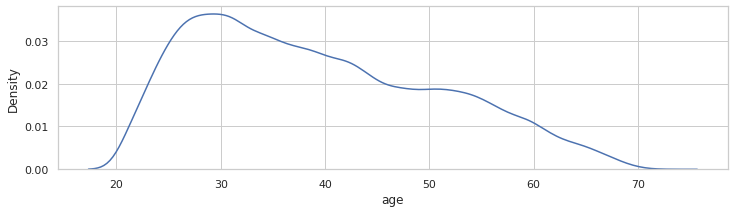

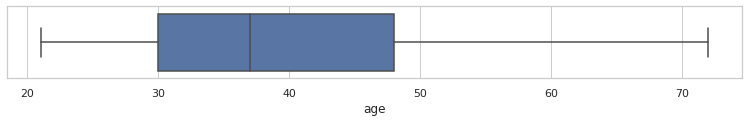

In [27]:
stats('age')

Смещение вправо в нем может носить естественный характер. Чем старше люди, тем реже они становятся клиентами банка, по крайней мере в качестве заемщиков. То же самое, можно сказать и о молодых людях. Возможно данный признак не нуждается в нормализации. 

Для логрегрессии этот признак является слабым, для случайного леса наоборот. Попробуем перевести его в категориальный:

In [28]:
data.age.value_counts(bins=10,normalize=True).sort_index()

(20.948, 26.1]   0.1341
(26.1, 31.2]     0.1820
(31.2, 36.3]     0.1576
(36.3, 41.4]     0.1365
(41.4, 46.5]     0.1128
(46.5, 51.6]     0.0940
(51.6, 56.7]     0.0865
(56.7, 61.8]     0.0591
(61.8, 66.9]     0.0303
(66.9, 72.0]     0.0072
Name: age, dtype: float64


0 - до 30 лет включительно

1 - от 31 до 40 лет включительно

2 - от 41 до 55 лет включительно

3 - от 56 лет и старше

In [29]:
num_cols_2 = num_cols.copy()
not_normalize_2 = not_normalize.copy()
cat_cols_2 = cat_cols.copy()
bin_cols_2 =bin_cols.copy()

In [30]:
def func(x):
    if x<31:
        return 0
    elif x<41:
        return 1
    elif x<56:
        return 2
    else:
        return 3
data['age_cat'] = data.age.apply(func)
data.age_cat.value_counts(normalize=True)

1   0.3059
2   0.3034
0   0.2791
3   0.1116
Name: age_cat, dtype: float64

In [31]:
num_cols_2.remove('age')
cat_cols_2.append('age_cat')

Признак **region_rating**

Сведения в данном признаке тоже выглядят как категориальные. Переведем его в соответствующую группу

In [32]:
region_dict = {i:int(i/10) for i in range(0,110,10)}
data['region_rating_cat'] = data['region_rating'].replace(region_dict)

In [33]:
num_cols_2.remove('region_rating')
cat_cols_2.append('region_rating_cat')

**day_of_week** и **day_of_month** заменим на рабочие/выходные и декады соответственно

In [34]:
data['day_of_month_cat'] = data.day_of_month.apply(lambda x: 1 if x in range(1, 11) else 2 if x in range(11, 21) else 3)
data['day_of_week_cat'] = data.day_of_week.apply(lambda x: 0 if x in [5,6] else 1)
num_cols_2.remove('day_of_week')
num_cols_2.remove('day_of_month')
cat_cols_2.extend(['day_of_week_cat','day_of_month_cat'])

Также уберем из рассмотрения признаки, имеющие небольшую важность для обоих моделей - пол и автомобили 

In [35]:
bin_cols_2 = ['good_work', 'foreign_passport']

Попробуем снова провести обучение моделей

In [36]:
cols_2 = num_cols_2+not_normalize_2+cat_cols_2+bin_cols_2
cols_2

['decline_app_cnt',
 'bki_request_cnt',
 'income',
 'score_bki',
 'education',
 'home_address',
 'work_address',
 'sna',
 'first_time',
 'age_cat',
 'region_rating_cat',
 'day_of_week_cat',
 'day_of_month_cat',
 'good_work',
 'foreign_passport']

In [37]:
data_metrics_2 = models_metrics(cols_2,num_cols_2,not_normalize_2)
for model in ['l_lr', 'l_rfc']:
    report_models(model, data_metrics_2)


Отчет для LogisticRegression: Oversampling


model  norm     sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
5  l_lr  n_pt  s_adasyn     0.2159  0.6913  8346  4587             35.4700   
1  l_lr  n_qt  s_adasyn     0.2169  0.6875  8397  4536             35.0700   
4  l_lr  n_pt   s_smote     0.2210  0.6798  8556  4377             33.8400   
0  l_lr  n_qt   s_smote     0.2204  0.6754  8569  4364             33.7400   

     tp   fn  approve_an_insolvent,%    ras  accuracy  
5  1263  564                 30.8700 0.7300    0.6510  
1  1256  571                 31.2500 0.7306    0.6540  
4  1242  585                 32.0200 0.7312    0.6638  
0  1234  593                 32.4600 0.7318    0.6642


Отчет для LogisticRegression: Undersampling


model  norm    sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
7  l_lr  n_pt  s_nmiss     0.1338  0.6831  4851  8082             62.4900   
3  l_lr  n_qt  s_nmiss     0.1327  0.6782  4837  8096             62.6000   
6  l_lr  n_pt    s_rus     0.2204  0.6831  8519  4414             34.1300   
2  l_lr  n_qt    s_rus     0.2206  0.6814  8534  4399             34.0100   

     tp   fn  approve_an_insolvent,%    ras  accuracy  
7  1248  579                 31.6900 0.5402    0.4132  
3  1239  588                 32.1800 0.5314    0.4117  
6  1248  579                 31.6900 0.7337    0.6617  
2  1245  582                 31.8600 0.7343    0.6625

Отчет для LogisticRegression: показатели Min Max



model  norm     sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
min  l_lr  n_pt  s_adasyn     0.1327  0.6754  4837  4364             33.7400   
max  l_lr  n_qt   s_smote     0.2210  0.6913  8569  8096             62.6000   

       tp   fn  approve_an_insolvent,%    ras  accuracy  
min  1234  564                 30.8700 0.5314    0.4117  
max  1263  593                 32.4600 0.7343    0.6642



Отчет для RandomForestClassifier: Oversampling


model  norm     sampl  precision  recall     tn   fp  refuse_a_solvent,%  \
13  l_rfc  n_pt  s_adasyn     0.2705  0.1171  12356  577              4.4600   
9   l_rfc  n_qt  s_adasyn     0.2838  0.1149  12403  530              4.1000   
12  l_rfc  n_pt   s_smote     0.2835  0.1297  12334  599              4.6300   
8   l_rfc  n_qt   s_smote     0.2943  0.1292  12367  566              4.3800   

     tp    fn  approve_an_insolvent,%    ras  accuracy  
13  214  1613                 88.2900 0.6872    0.8516  
9   210  1617                 88.5100 0.6900    0.8545  
12  237  1590                 87.0300 0.6976    0.8517  
8   236  1591                 87.0800 0.6922    0.8539


Отчет для RandomForestClassifier: Undersampling


model  norm    sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
15  l_rfc  n_pt  s_nmiss     0.1252  0.7761  3022  9911             76.6300   
11  l_rfc  n_qt  s_nmiss     0.1240  0.7619  3103  9830             76.0100   
14  l_rfc  n_pt    s_rus     0.2052  0.6721  8178  4755             36.7700   
10  l_rfc  n_qt    s_rus     0.2056  0.6727  8183  4750             36.7300   

      tp   fn  approve_an_insolvent,%    ras  accuracy  
15  1418  409                 22.3900 0.5278    0.3008  
11  1392  435                 23.8100 0.5198    0.3045  
14  1228  599                 32.7900 0.7101    0.6373  
10  1229  598                 32.7300 0.7104    0.6377

Отчет для RandomForestClassifier: показатели Min Max



model  norm     sampl  precision  recall     tn    fp  \
min  l_rfc  n_pt  s_adasyn     0.1240  0.1149   3022   530   
max  l_rfc  n_qt   s_smote     0.2943  0.7761  12403  9911   

     refuse_a_solvent,%    tp    fn  approve_an_insolvent,%    ras  accuracy  
min              4.1000   210   409                 22.3900 0.5198    0.3008  
max             76.6300  1418  1617                 88.5100 0.7104    0.8545

In [38]:
display(data_metrics.agg([min,max]))
display(data_metrics_2.agg([min,max]))

model  norm     sampl  precision  recall     tn    fp  \
min   l_lr  n_pt  s_adasyn     0.1255  0.0777   3186   302   
max  l_rfc  n_qt   s_smote     0.3430  0.7657  12631  9747   

     refuse_a_solvent,%    tp    fn  approve_an_insolvent,%    ras  accuracy  
min              2.3400   142   428                 23.4300 0.4994    0.3106  
max             75.3700  1399  1685                 92.2300 0.7378    0.8659

model  norm     sampl  precision  recall     tn    fp  \
min   l_lr  n_pt  s_adasyn     0.1240  0.1149   3022   530   
max  l_rfc  n_qt   s_smote     0.2943  0.7761  12403  9911   

     refuse_a_solvent,%    tp    fn  approve_an_insolvent,%    ras  accuracy  
min              4.1000   210   409                 22.3900 0.5198    0.3008  
max             76.6300  1418  1617                 88.5100 0.7343    0.8545

В целом ситуация с показателямин практически не изменилась

# **Обучение с сэмплингом. Попытка 3**

**income** Посмотрим на распределение дохода заемщиков

In [39]:
data.income.value_counts(bins=20, normalize=True).sort_index()

(0.999, 50950.0]        0.8138
(50950.0, 100900.0]     0.1437
(100900.0, 150850.0]    0.0241
(150850.0, 200800.0]    0.0088
(200800.0, 250750.0]    0.0031
(250750.0, 300700.0]    0.0029
(300700.0, 350650.0]    0.0006
(350650.0, 400600.0]    0.0008
(400600.0, 450550.0]    0.0002
(450550.0, 500500.0]    0.0008
(500500.0, 550450.0]    0.0001
(550450.0, 600400.0]    0.0003
(600400.0, 650350.0]    0.0000
(650350.0, 700300.0]    0.0002
(700300.0, 750250.0]    0.0000
(750250.0, 800200.0]    0.0001
(800200.0, 850150.0]    0.0000
(850150.0, 900100.0]    0.0001
(900100.0, 950050.0]    0.0001
(950050.0, 1000000.0]   0.0002
Name: income, dtype: float64

Большинство заемщиков - 96% - имеет доход не более 101_000

In [40]:
data.income[data.income.between(1000,101000)].value_counts(bins=10,normalize=True).sort_index()

(899.999, 11000.0]    0.0670
(11000.0, 21000.0]    0.2431
(21000.0, 31000.0]    0.2608
(31000.0, 41000.0]    0.1641
(41000.0, 51000.0]    0.1155
(51000.0, 61000.0]    0.0547
(61000.0, 71000.0]    0.0350
(71000.0, 81000.0]    0.0259
(81000.0, 91000.0]    0.0119
(91000.0, 101000.0]   0.0220
Name: income, dtype: float64

Из них 77% не более 51_000. Учитывая, что медианное значение для признака 30_000, вместо нормализации, разделим клиентов на категории:

|категория|диапазон|
|:-|:-
|0|<=21_000
|1|21_001 - 31_000
|2|31_001 - 50_000
|3|50_001 - 101_000
|4|> 101_000

In [41]:
num_cols_3 = num_cols_2.copy()
not_normalize_3 = not_normalize_2.copy()
cat_cols_3 = cat_cols_2.copy()
bin_cols_3 =bin_cols_2.copy()

In [42]:
def income_cat(x):
    if x <= 21000:
        x = 0
    elif x <= 31000:
        x = 1
    elif x <= 50000:
        x = 2
    elif x <=101000:
        x = 3
    else:
        x = 4
    return x
data['income_cat'] = data.income.apply(income_cat)


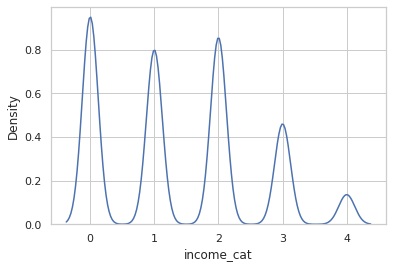

In [43]:
sns.kdeplot(data['income_cat'])

In [44]:
num_cols_3.remove('income')
cat_cols_3.append('income_cat')

Рассмотрим признак **region_rating**

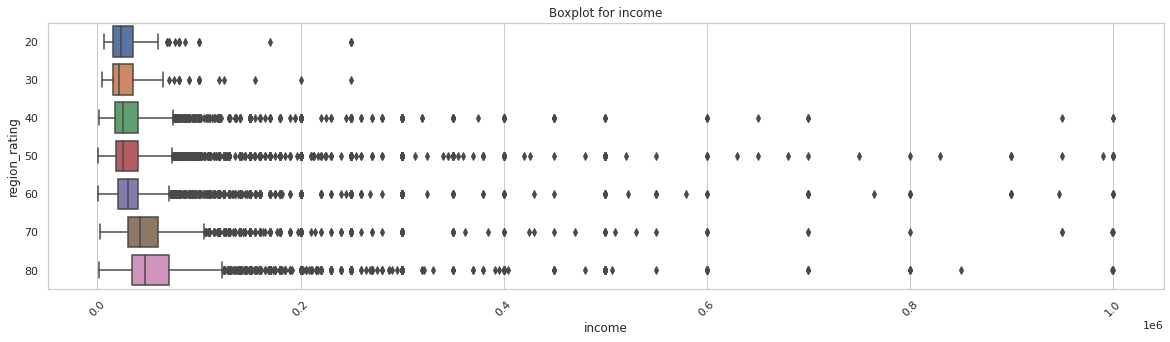

In [45]:
get_boxplot('region_rating','income','h')

Видим, что у региона 20 и 30 имеется потолок по доходам

In [46]:
data.groupby('region_rating')['income'].max()

region_rating
20     250000
30     250000
40    1000000
50    1000000
60    1000000
70     999999
80    1000000
Name: income, dtype: int64

Также видим, что чем выше рейтинг региона, тем уровень доходов большинства выше. Возможно это говорит о том, что один и тот же уровень дохода в разных регионах имеет разное значение. Т.е. 100_000 в регионе 20 это совсем не то же самое, что 100_000 в регионе 80. Попробуем ввести дополнительный признак - соотношение дохода к правой границе выброса в регионе

In [47]:
income_dict = {}
for value in data.region_rating.unique():
    value_part = data.income[data.region_rating==value]
    max_point = value_part.quantile(0.75) + 1.5*(value_part.quantile(0.75)-value_part.quantile(0.25))
    income_dict[value] = max_point
data['income_rating'] = data[['region_rating','income']].apply(lambda x: x[1]/income_dict[x[0]],axis=1)

In [48]:
data[['income','income_rating']].corr()

income  income_rating
income         1.0000         0.9552
income_rating  0.9552         1.0000

In [49]:
data[['income','income_rating','region_rating']][data.income==100000][:10]

income  income_rating  region_rating
28   100000         0.8114             80
76   100000         1.3699             50
86   100000         1.3699             50
196  100000         1.4286             60
291  100000         1.3699             50
300  100000         1.3699             50
314  100000         1.3699             50
394  100000         1.4286             60
423  100000         1.3699             50
446  100000         1.3699             50

Видно, что один и тот же доход теперь имеет разный "вес", но при этом сам признак получился сильно скоррелирован с **income**, использовать их одновременно не стоит. Но оставим пока **income_rating** для возможных дальнейших вычислений

Признаки **sna, first_time, home_address, work_address** относятся к категориальным, не имеют расшифровок, корреляции друг с другом или целевой переменной.

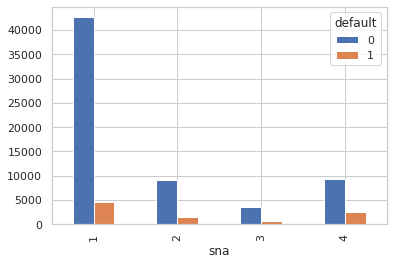

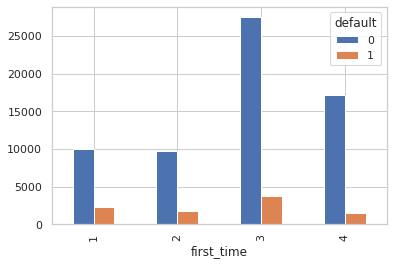

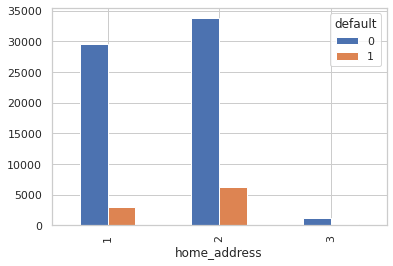

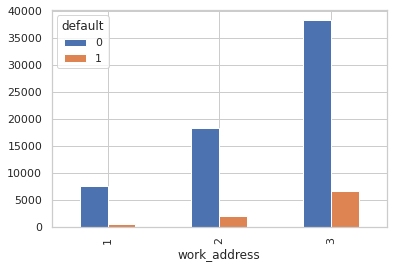

In [50]:
for column in ['sna','first_time','home_address','work_address']:
    pd.crosstab(data[column],data.default).plot(kind='bar')
    plt.show()

Не понятно, что можно с ними сделать, но они имеют высокую/средню важность для моделей, поэтому оставлю их и оставлю как есть.

Из всех идей остались только полиномиальные признаки. Применим к **decline_app_cnt, bki_request_cnt, score_bki, income_rating** PolynomialFeatures.

In [51]:
print('Распределение отказов в выдаче кредитов')
display(data.decline_app_cnt.value_counts(normalize=True))
print('Распределение запросов в БКИ при остутствии отказов в выдаче кредитов')
display(data[data.decline_app_cnt==0]['bki_request_cnt'].value_counts(normalize=True))

Распределение отказов в выдаче кредитов


0    0.8295
1    0.1138
2    0.0334
3    0.0122
4    0.0056
5    0.0022
6    0.0015
7    0.0007
9    0.0003
8    0.0003
10   0.0001
11   0.0001
13   0.0000
12   0.0000
14   0.0000
16   0.0000
24   0.0000
15   0.0000
19   0.0000
22   0.0000
33   0.0000
Name: decline_app_cnt, dtype: float64

Распределение запросов в БКИ при остутствии отказов в выдаче кредитов


0    0.2743
1    0.2552
2    0.1866
3    0.1227
4    0.0733
5    0.0420
6    0.0204
7    0.0098
8    0.0051
9    0.0028
11   0.0019
10   0.0019
12   0.0011
14   0.0008
13   0.0007
15   0.0004
16   0.0003
18   0.0001
19   0.0001
21   0.0001
17   0.0001
20   0.0001
25   0.0000
22   0.0000
23   0.0000
24   0.0000
28   0.0000
41   0.0000
53   0.0000
32   0.0000
Name: bki_request_cnt, dtype: float64

In [52]:
print('Распределение запросов в БКИ')
display(data.bki_request_cnt.value_counts(normalize=True))
print('Распределение отказов в выдаче кредитов при отсутствии запросов в БКИ')
display(data[data.bki_request_cnt==0]['decline_app_cnt'].value_counts(normalize=True))

Распределение запросов в БКИ


0    0.2626
1    0.2476
2    0.1863
3    0.1245
4    0.0762
      ...  
34   0.0000
36   0.0000
41   0.0000
45   0.0000
53   0.0000
Name: bki_request_cnt, Length: 38, dtype: float64

Распределение отказов в выдаче кредитов при отсутствии запросов в БКИ


0    0.8665
1    0.0925
2    0.0255
3    0.0083
4    0.0032
5    0.0018
6    0.0010
7    0.0005
10   0.0002
8    0.0002
13   0.0001
9    0.0001
14   0.0001
11   0.0001
Name: decline_app_cnt, dtype: float64

При этом, учитывая, что в **decline_app_cnt и bki_request_cnt** сильный дисбаланс в сторону 0, сместим значения в признаках на 1.

In [53]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
data['decline_app_cnt_temp'] = data['decline_app_cnt']+1
data['bki_request_cnt_temp'] = data['bki_request_cnt']+1
poly = poly.fit_transform(data[['decline_app_cnt_temp','bki_request_cnt_temp','score_bki','age','income_rating']])
poly = pd.DataFrame(poly,columns=['poly_'+str(i+1) for i in range(poly.shape[1])])
data = pd.concat([data,poly],axis=1)
data.drop(columns=['decline_app_cnt_temp','bki_request_cnt_temp'],inplace=True)

In [54]:
data.sample()

education  age  car  car_type  decline_app_cnt  good_work  score_bki  \
7725          0   53    0         0                0          1    -1.5720   

      bki_request_cnt  region_rating  home_address  work_address  income  sna  \
7725                2             60             1             2   23000    1   

      first_time  foreign_passport  default  sex_F  sex_M car_type_new  d_car  \
7725           3                 0        0      1      0       no_car      0   

      f_car  no_car  day_of_month  day_of_week  age_cat  region_rating_cat  \
7725      0       1             8            5        2                  6   

      day_of_month_cat  day_of_week_cat  income_cat  income_rating  poly_1  \
7725                 1                0           1         0.3286  1.0000   

      poly_2  poly_3  poly_4  poly_5  poly_6  poly_7  poly_8  poly_9  poly_10  \
7725  1.0000  3.0000 -1.5720 53.0000  0.3286  1.0000  3.0000 -1.5720  53.0000   

      poly_11  poly_12  poly_13  poly_14  poly_15  poly_16  poly_17  poly_18  \
7725   0.3286   9.0000  -4.7159 159.0000   0.9857   2.4711 -83.3149  -0.5165   

       poly_19  poly_20  poly_21  
7725 2809.0000  17.4143   0.1080

In [55]:
num_cols_3.extend(poly.columns.to_list())

И, напоследок, попробую **decline_app_cnt и bki_request_cnt** убрать в бинарную категорию (0 - не было отказов/запросов, 1 - были)

In [56]:
data['decline_app_cnt_temp'] = data['decline_app_cnt'].apply(lambda x: x if x == 0 else 1)
data = pd.concat([data,pd.get_dummies(data.decline_app_cnt_temp,prefix='decline_app_cnt')],axis=1)
data['bki_request_cnt_temp'] = data['bki_request_cnt'].apply(lambda x: x if x == 0 else 1)
data = pd.concat([data,pd.get_dummies(data.bki_request_cnt_temp,prefix='bki_request_cnt')],axis=1)
data.drop(columns=['decline_app_cnt_temp','bki_request_cnt_temp'],inplace=True)
data.sample()

education  age  car  car_type  decline_app_cnt  good_work  score_bki  \
68851          0   55    1         1                0          0    -1.8762   

       bki_request_cnt  region_rating  home_address  work_address  income  \
68851                4             80             2             3   30000   

       sna  first_time  foreign_passport  default  sex_F  sex_M car_type_new  \
68851    1           3                 1        0      0      1        f_car   

       d_car  f_car  no_car  day_of_month  day_of_week  age_cat  \
68851      0      1       0            23            3        2   

       region_rating_cat  day_of_month_cat  day_of_week_cat  income_cat  \
68851                  8                 3                1           1   

       income_rating  poly_1  poly_2  poly_3  poly_4  poly_5  poly_6  poly_7  \
68851         0.2434  1.0000  1.0000  5.0000 -1.8762 55.0000  0.2434  1.0000   

       poly_8  poly_9  poly_10  poly_11  poly_12  poly_13  poly_14  poly_15  \
68851  5.0000 -1.8762  55.0000   0.2434  25.0000  -9.3810 275.0000   1.2170   

       poly_16   poly_17  poly_18   poly_19  poly_20  poly_21  \
68851   3.5201 -103.1911  -0.4567 3025.0000  13.3874   0.0592   

       decline_app_cnt_0  decline_app_cnt_1  bki_request_cnt_0  \
68851                  1                  0                  0   

       bki_request_cnt_1  
68851                  1

In [57]:
bin_cols_3.extend(['decline_app_cnt_0','decline_app_cnt_1','bki_request_cnt_0','bki_request_cnt_1'])
num_cols_3.remove('decline_app_cnt')
num_cols_3.remove('bki_request_cnt')
num_cols_3.append('income_rating')

In [58]:
cols_3 = num_cols_3+not_normalize_3+cat_cols_3+bin_cols_3
np.array(cols_3)

array(['poly_1', 'poly_2', 'poly_3', 'poly_4', 'poly_5', 'poly_6',
       'poly_7', 'poly_8', 'poly_9', 'poly_10', 'poly_11', 'poly_12',
       'poly_13', 'poly_14', 'poly_15', 'poly_16', 'poly_17', 'poly_18',
       'poly_19', 'poly_20', 'poly_21', 'income_rating', 'score_bki',
       'education', 'home_address', 'work_address', 'sna', 'first_time',
       'age_cat', 'region_rating_cat', 'day_of_week_cat',
       'day_of_month_cat', 'income_cat', 'good_work', 'foreign_passport',
       'decline_app_cnt_0', 'decline_app_cnt_1', 'bki_request_cnt_0',
       'bki_request_cnt_1'], dtype='<U17')


И в третий раз закинул старик невод в море ))

In [59]:
data_metrics_3 = models_metrics(cols_3,num_cols_3,not_normalize_3)
for model in ['l_lr', 'l_rfc']:
    report_models(model, data_metrics_3)


Отчет для LogisticRegression: Oversampling


model  norm     sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
5  l_lr  n_pt  s_adasyn     0.2182  0.6940  8390  4543             35.1300   
1  l_lr  n_qt  s_adasyn     0.2175  0.6875  8414  4519             34.9400   
4  l_lr  n_pt   s_smote     0.2222  0.6787  8593  4340             33.5600   
0  l_lr  n_qt   s_smote     0.2220  0.6776  8594  4339             33.5500   

     tp   fn  approve_an_insolvent,%    ras  accuracy  
5  1268  559                 30.6000 0.7304    0.6543  
1  1256  571                 31.2500 0.7295    0.6551  
4  1240  587                 32.1300 0.7317    0.6662  
0  1238  589                 32.2400 0.7313    0.6661


Отчет для LogisticRegression: Undersampling


model  norm    sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
7  l_lr  n_pt  s_nmiss     0.1339  0.6902  4780  8153             63.0400   
3  l_lr  n_qt  s_nmiss     0.1361  0.6880  4955  7978             61.6900   
6  l_lr  n_pt    s_rus     0.2211  0.6847  8527  4406             34.0700   
2  l_lr  n_qt    s_rus     0.2203  0.6809  8530  4403             34.0400   

     tp   fn  approve_an_insolvent,%    ras  accuracy  
7  1261  566                 30.9800 0.5406    0.4093  
3  1257  570                 31.2000 0.5499    0.4209  
6  1251  576                 31.5300 0.7341    0.6625  
2  1244  583                 31.9100 0.7332    0.6622

Отчет для LogisticRegression: показатели Min Max



model  norm     sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
min  l_lr  n_pt  s_adasyn     0.1339  0.6776  4780  4339             33.5500   
max  l_lr  n_qt   s_smote     0.2222  0.6940  8594  8153             63.0400   

       tp   fn  approve_an_insolvent,%    ras  accuracy  
min  1238  559                 30.6000 0.5406    0.4093  
max  1268  589                 32.2400 0.7341    0.6662



Отчет для RandomForestClassifier: Oversampling


model  norm     sampl  precision  recall     tn   fp  refuse_a_solvent,%  \
13  l_rfc  n_pt  s_adasyn     0.2947  0.0974  12507  426              3.2900   
9   l_rfc  n_qt  s_adasyn     0.2913  0.0985  12495  438              3.3900   
12  l_rfc  n_pt   s_smote     0.2967  0.1018  12492  441              3.4100   
8   l_rfc  n_qt   s_smote     0.3030  0.1166  12443  490              3.7900   

     tp    fn  approve_an_insolvent,%    ras  accuracy  
13  178  1649                 90.2600 0.6856    0.8594  
9   180  1647                 90.1500 0.6852    0.8587  
12  186  1641                 89.8200 0.6874    0.8589  
8   213  1614                 88.3400 0.6880    0.8575


Отчет для RandomForestClassifier: Undersampling


model  norm    sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
15  l_rfc  n_pt  s_nmiss     0.1313  0.7329  4072  8861             68.5100   
11  l_rfc  n_qt  s_nmiss     0.1348  0.7291  4381  8552             66.1300   
14  l_rfc  n_pt    s_rus     0.2033  0.6612  8200  4733             36.6000   
10  l_rfc  n_qt    s_rus     0.2024  0.6508  8248  4685             36.2300   

      tp   fn  approve_an_insolvent,%    ras  accuracy  
15  1339  488                 26.7100 0.5552    0.3666  
11  1332  495                 27.0900 0.5646    0.3871  
14  1208  619                 33.8800 0.6999    0.6374  
10  1189  638                 34.9200 0.7007    0.6394

Отчет для RandomForestClassifier: показатели Min Max



model  norm     sampl  precision  recall     tn    fp  \
min  l_rfc  n_pt  s_adasyn     0.1313  0.0974   4072   426   
max  l_rfc  n_qt   s_smote     0.3030  0.7329  12507  8861   

     refuse_a_solvent,%    tp    fn  approve_an_insolvent,%    ras  accuracy  
min              3.2900   178   488                 26.7100 0.5552    0.3666  
max             68.5100  1339  1649                 90.2600 0.7007    0.8594

In [60]:
display(data_metrics.agg([min,max]))
display(data_metrics_2.agg([min,max]))
display(data_metrics_3.agg([min,max]))

model  norm     sampl  precision  recall     tn    fp  \
min   l_lr  n_pt  s_adasyn     0.1255  0.0777   3186   302   
max  l_rfc  n_qt   s_smote     0.3430  0.7657  12631  9747   

     refuse_a_solvent,%    tp    fn  approve_an_insolvent,%    ras  accuracy  
min              2.3400   142   428                 23.4300 0.4994    0.3106  
max             75.3700  1399  1685                 92.2300 0.7378    0.8659

model  norm     sampl  precision  recall     tn    fp  \
min   l_lr  n_pt  s_adasyn     0.1240  0.1149   3022   530   
max  l_rfc  n_qt   s_smote     0.2943  0.7761  12403  9911   

     refuse_a_solvent,%    tp    fn  approve_an_insolvent,%    ras  accuracy  
min              4.1000   210   409                 22.3900 0.5198    0.3008  
max             76.6300  1418  1617                 88.5100 0.7343    0.8545

model  norm     sampl  precision  recall     tn    fp  \
min   l_lr  n_pt  s_adasyn     0.1313  0.0974   4072   426   
max  l_rfc  n_qt   s_smote     0.3030  0.7329  12507  8861   

     refuse_a_solvent,%    tp    fn  approve_an_insolvent,%    ras  accuracy  
min              3.2900   178   488                 26.7100 0.5406    0.3666  
max             68.5100  1339  1649                 90.2600 0.7341    0.8594

Если сравнивать результаты по **approve_an_insolvent**, то в последнем варианте для логрегрессиии на оверсемплинге и на андерсемплинге с алгоритмом rus достигнуты наименьшие показатели. Модель случайного леса так и продолжает показывать неудовлетворительные результаты.

# **Обучение с сэмплингом. Попытка 4**

Теперь попробуем передать моделям все имеющиеся у нас признаки (кроме default и car_type_new)

In [61]:
data.columns.values

array(['education', 'age', 'car', 'car_type', 'decline_app_cnt',
       'good_work', 'score_bki', 'bki_request_cnt', 'region_rating',
       'home_address', 'work_address', 'income', 'sna', 'first_time',
       'foreign_passport', 'default', 'sex_F', 'sex_M', 'car_type_new',
       'd_car', 'f_car', 'no_car', 'day_of_month', 'day_of_week',
       'age_cat', 'region_rating_cat', 'day_of_month_cat',
       'day_of_week_cat', 'income_cat', 'income_rating', 'poly_1',
       'poly_2', 'poly_3', 'poly_4', 'poly_5', 'poly_6', 'poly_7',
       'poly_8', 'poly_9', 'poly_10', 'poly_11', 'poly_12', 'poly_13',
       'poly_14', 'poly_15', 'poly_16', 'poly_17', 'poly_18', 'poly_19',
       'poly_20', 'poly_21', 'decline_app_cnt_0', 'decline_app_cnt_1',
       'bki_request_cnt_0', 'bki_request_cnt_1'], dtype=object)

In [62]:
num_cols_all = ['age','income','day_of_month','day_of_week','income_rating','decline_app_cnt','bki_request_cnt','poly_1', 'poly_2',
              'poly_3', 'poly_4', 'poly_5', 'poly_6', 'poly_7', 'poly_8', 'poly_9',
              'poly_10', 'poly_11', 'poly_12', 'poly_13', 'poly_14', 'poly_15',
              'poly_16', 'poly_17', 'poly_18', 'poly_19', 'poly_20', 'poly_21']
not_normalize_all = ['score_bki']
cat_cols_all = ['education', 'car', 'car_type', 'region_rating','home_address', 'work_address', 'sna', 'first_time', 'age_cat', 'region_rating_cat', 'day_of_month_cat',
       'day_of_week_cat', 'income_cat', ]
bin_cols_all = ['good_work','foreign_passport','sex_F', 'sex_M','d_car', 'f_car', 'no_car','decline_app_cnt_0', 'decline_app_cnt_1', 'bki_request_cnt_0',
       'bki_request_cnt_1']
cols_all = num_cols_all+not_normalize_all+cat_cols_all+bin_cols_all
np.array(cols_all)

array(['age', 'income', 'day_of_month', 'day_of_week', 'income_rating',
       'decline_app_cnt', 'bki_request_cnt', 'poly_1', 'poly_2', 'poly_3',
       'poly_4', 'poly_5', 'poly_6', 'poly_7', 'poly_8', 'poly_9',
       'poly_10', 'poly_11', 'poly_12', 'poly_13', 'poly_14', 'poly_15',
       'poly_16', 'poly_17', 'poly_18', 'poly_19', 'poly_20', 'poly_21',
       'score_bki', 'education', 'car', 'car_type', 'region_rating',
       'home_address', 'work_address', 'sna', 'first_time', 'age_cat',
       'region_rating_cat', 'day_of_month_cat', 'day_of_week_cat',
       'income_cat', 'good_work', 'foreign_passport', 'sex_F', 'sex_M',
       'd_car', 'f_car', 'no_car', 'decline_app_cnt_0',
       'decline_app_cnt_1', 'bki_request_cnt_0', 'bki_request_cnt_1'],
      dtype='<U17')

In [63]:
data_metrics_all = models_metrics(cols_all,num_cols_all,not_normalize_all)
for model in ['l_lr', 'l_rfc']:
    report_models(model, data_metrics_all)


Отчет для LogisticRegression: Oversampling


model  norm     sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
5  l_lr  n_pt  s_adasyn     0.2189  0.6968  8391  4542             35.1200   
1  l_lr  n_qt  s_adasyn     0.2191  0.6897  8442  4491             34.7300   
4  l_lr  n_pt   s_smote     0.2216  0.6765  8592  4341             33.5700   
0  l_lr  n_qt   s_smote     0.2230  0.6743  8641  4292             33.1900   

     tp   fn  approve_an_insolvent,%    ras  accuracy  
5  1273  554                 30.3200 0.7346    0.6547  
1  1260  567                 31.0300 0.7350    0.6573  
4  1236  591                 32.3500 0.7366    0.6659  
0  1232  595                 32.5700 0.7368    0.6689


Отчет для LogisticRegression: Undersampling


model  norm    sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
7  l_lr  n_pt  s_nmiss     0.1306  0.7263  4097  8836             68.3200   
3  l_lr  n_qt  s_nmiss     0.1307  0.7280  4088  8845             68.3900   
6  l_lr  n_pt    s_rus     0.2206  0.6891  8484  4449             34.4000   
2  l_lr  n_qt    s_rus     0.2228  0.6847  8569  4364             33.7400   

     tp   fn  approve_an_insolvent,%    ras  accuracy  
7  1327  500                 27.3700 0.5256    0.3675  
3  1330  497                 27.2000 0.5260    0.3671  
6  1259  568                 31.0900 0.7377    0.6601  
2  1251  576                 31.5300 0.7385    0.6653

Отчет для LogisticRegression: показатели Min Max



model  norm     sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
min  l_lr  n_pt  s_adasyn     0.1306  0.6743  4088  4292             33.1900   
max  l_lr  n_qt   s_smote     0.2230  0.7280  8641  8845             68.3900   

       tp   fn  approve_an_insolvent,%    ras  accuracy  
min  1232  497                 27.2000 0.5256    0.3671  
max  1330  595                 32.5700 0.7385    0.6689



Отчет для RandomForestClassifier: Oversampling


model  norm     sampl  precision  recall     tn   fp  refuse_a_solvent,%  \
13  l_rfc  n_pt  s_adasyn     0.3247  0.0684  12673  260              2.0100   
9   l_rfc  n_qt  s_adasyn     0.3236  0.0668  12678  255              1.9700   
12  l_rfc  n_pt   s_smote     0.3342  0.0706  12676  257              1.9900   
8   l_rfc  n_qt   s_smote     0.3157  0.0717  12649  284              2.2000   

     tp    fn  approve_an_insolvent,%    ras  accuracy  
13  125  1702                 93.1600 0.6960    0.8671  
9   122  1705                 93.3200 0.6988    0.8672  
12  129  1698                 92.9400 0.6993    0.8675  
8   131  1696                 92.8300 0.6973    0.8659


Отчет для RandomForestClassifier: Undersampling


model  norm    sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
15  l_rfc  n_pt  s_nmiss     0.1330  0.7427  4085  8848             68.4100   
11  l_rfc  n_qt  s_nmiss     0.1317  0.7406  4015  8918             68.9600   
14  l_rfc  n_pt    s_rus     0.2055  0.6678  8215  4718             36.4800   
10  l_rfc  n_qt    s_rus     0.2071  0.6661  8275  4658             36.0200   

      tp   fn  approve_an_insolvent,%    ras  accuracy  
15  1357  470                 25.7300 0.5411    0.3687  
11  1353  474                 25.9400 0.5362    0.3637  
14  1220  607                 33.2200 0.7089    0.6392  
10  1217  610                 33.3900 0.7094    0.6431

Отчет для RandomForestClassifier: показатели Min Max



model  norm     sampl  precision  recall     tn    fp  \
min  l_rfc  n_pt  s_adasyn     0.1317  0.0668   4015   255   
max  l_rfc  n_qt   s_smote     0.3342  0.7427  12678  8918   

     refuse_a_solvent,%    tp    fn  approve_an_insolvent,%    ras  accuracy  
min              1.9700   122   470                 25.7300 0.5362    0.3637  
max             68.9600  1357  1705                 93.3200 0.7094    0.8675

И снова имеются незначительные улучшения. Для дальнейшей работы попробуем отобрать не более 20 признаков, имеющих наибольшее значение для моделей и на этих наборах осуществить настройку параметров самих моделей. Нормализацию и сэмплинг выберем на основе предыдущих результатов

# **Обучение с сэмплингом. Попытка 5**

**LogisticRegression**

In [64]:
# Задание параметров для процесса поиска
independent_features = data[cols_all].values
target_feature = data['default'].values
# Модели
l_lr = LogisticRegression(random_state=42)
learning_models = [l_lr]
# Семплинг
s_smote = SMOTE(random_state=42)
s_adasyn = ADASYN(random_state=42)
s_rus = RandomUnderSampler(random_state=42)
sampling_models = [s_smote, s_adasyn, s_rus]
# Нормализация данных
n_pt = PowerTransformer()
norm_models = [n_pt]
lear = ['l_lr']
norm = ['n_pt']
sampl = ['s_smote', 's_adasyn', 's_rus']
norm_copy = norm.copy()
sampl_copy = sampl.copy()
# табличный вид полученных результатов
data_features_lr = pd.DataFrame(columns=['model', 'norm', 'sampl', 'features'])
# количество наиболее важных признаков 
n_feat = 20

for learning_model in learning_models:
    for norm_model in norm_models:
        for sampling_model in sampling_models:
            models = [lear[0], norm[0], sampl[0]]
            rfe = feature_selection(independent_features, target_feature,
                                        norm_model, sampling_model,
                                        learning_model, num_cols_all,not_normalize_all,n_feat)
            features = pd.Series(cols_all)[pd.Series(rfe.get_support())].to_list()
            models.append(features)
            data_temp = pd.DataFrame([models], columns=['model', 'norm', 'sampl', 'features'])
            data_features_lr = pd.concat([data_features_lr, data_temp], ignore_index=True)
            sampl.pop(0)
        sampl = sampl_copy.copy()
        norm.pop(0)
    norm = norm_copy.copy()
    lear.pop(0)

In [65]:
lr_impotant = pd.concat([pd.DataFrame(list('+'*len(data_features_lr.features[0])),
                        index=data_features_lr.features[0],
                        columns = [data_features_lr.model[0]+'_'+data_features_lr.norm[0]+'_'+data_features_lr.sampl[0]]),
           pd.DataFrame(list('+'*len(data_features_lr.features[1])), index=data_features_lr.features[1],
                        columns = [data_features_lr.model[1]+'_'+data_features_lr.norm[1]+'_'+data_features_lr.sampl[1]]),
           pd.DataFrame(list('+'*len(data_features_lr.features[2])), index=data_features_lr.features[2],
                        columns = [data_features_lr.model[2]+'_'+data_features_lr.norm[2]+'_'+data_features_lr.sampl[2]])],
          axis=1)
lr_impotant

l_lr_n_pt_s_smote l_lr_n_pt_s_adasyn l_lr_n_pt_s_rus
bki_request_cnt                   +                  +             NaN
poly_3                            +                  +             NaN
poly_4                            +                  +               +
poly_10                           +                  +               +
poly_11                           +                  +               +
poly_14                           +                  +               +
poly_16                           +                  +               +
poly_17                           +                  +               +
poly_18                           +                  +               +
score_bki                         +                  +               +
education                         +                NaN               +
home_address                      +                  +               +
work_address                      +                  +               +
income_cat                        +                  +               +
good_work                         +                  +               +
foreign_passport                  +                  +               +
sex_F                             +                  +               +
sex_M                             +                NaN             NaN
f_car                             +                NaN             NaN
decline_app_cnt_0                 +                  +             NaN
poly_12                         NaN                  +             NaN
poly_13                         NaN                  +               +
car_type                        NaN                  +               +
age                             NaN                NaN               +
poly_5                          NaN                NaN               +
poly_15                         NaN                NaN               +

**RandomForestClassifier**

In [66]:
# Задание параметров для процесса поиска
independent_features = data[cols_all].values
target_feature = data['default'].values
# Модели
l_rfc = RandomForestClassifier(random_state=42)
learning_models = [l_rfc]
# Семплинг
s_rus = RandomUnderSampler(random_state=42)
s_nmiss = NearMiss()
sampling_models = [s_rus, s_nmiss]
# Нормализация данных
n_pt = PowerTransformer()
norm_models = [n_pt]
lear = ['l_rfc']
norm = ['n_pt']
sampl = ['s_rus', 's_nmiss']
norm_copy = norm.copy()
sampl_copy = sampl.copy()
# табличный вид полученных результатов
data_features_rf = pd.DataFrame(columns=['model', 'norm', 'sampl', 'features'])
# количество наиболее важных признаков 
n_feat = 20

for learning_model in learning_models:
    for norm_model in norm_models:
        for sampling_model in sampling_models:
            models = [lear[0], norm[0], sampl[0]]
            rfe = feature_selection(independent_features, target_feature,
                                        norm_model, sampling_model,
                                        learning_model, num_cols_all,not_normalize_all,n_feat)
            features = pd.Series(cols_all)[pd.Series(rfe.get_support())].to_list()
            models.append(features)
            data_temp = pd.DataFrame([models], columns=['model', 'norm', 'sampl', 'features'])
            data_features_rf = pd.concat([data_features_rf, data_temp], ignore_index=True)
            sampl.pop(0)
        sampl = sampl_copy.copy()
        norm.pop(0)
    norm = norm_copy.copy()
    lear.pop(0)

In [84]:
rf_important = pd.concat([pd.DataFrame(list('+'*len(data_features_rf.features[0])),
                        index=data_features_rf.features[0],
                        columns = [data_features_rf.model[0]+'_'+data_features_rf.norm[0]+'_'+data_features_rf.sampl[0]]),
           pd.DataFrame(list('+'*len(data_features_rf.features[1])), index=data_features_rf.features[1],
                        columns = [data_features_rf.model[1]+'_'+data_features_rf.norm[1]+'_'+data_features_rf.sampl[1]])],
          axis=1)
rf_important

l_rfc_n_pt_s_rus l_rfc_n_pt_s_nmiss
age                              +                NaN
day_of_month                     +                  +
income_rating                    +                  +
poly_4                           +                  +
poly_5                           +                  +
poly_6                           +                  +
poly_9                           +                  +
poly_10                          +                  +
poly_11                          +                  +
poly_13                          +                  +
poly_14                          +                  +
poly_15                          +                  +
poly_16                          +                  +
poly_17                          +                  +
poly_18                          +                  +
poly_20                          +                  +
poly_21                          +                NaN
score_bki                        +                  +
sna                              +                NaN
region_rating_cat                +                NaN
income                         NaN                  +
day_of_week                    NaN                  +
car                            NaN                  +
no_car                         NaN                  +

Отберем признаки, где у всех алгоритмов указаны "+" отдельно для каждой модели:

- для **LogisticRegression** 14 признаков

In [68]:
lr_impotant[(lr_impotant.l_lr_n_pt_s_smote=='+')&(lr_impotant.l_lr_n_pt_s_adasyn=='+')&((lr_impotant.l_lr_n_pt_s_rus=='+'))]

l_lr_n_pt_s_smote l_lr_n_pt_s_adasyn l_lr_n_pt_s_rus
poly_4                           +                  +               +
poly_10                          +                  +               +
poly_11                          +                  +               +
poly_14                          +                  +               +
poly_16                          +                  +               +
poly_17                          +                  +               +
poly_18                          +                  +               +
score_bki                        +                  +               +
home_address                     +                  +               +
work_address                     +                  +               +
income_cat                       +                  +               +
good_work                        +                  +               +
foreign_passport                 +                  +               +
sex_F                            +                  +               +

In [69]:
num_cols_lr = ['poly_4','poly_10','poly_11','poly_14','poly_16','poly_17','poly_18']
not_normalize_lr = ['score_bki']
cat_cols_lr = ['home_address','work_address','income_cat']
bin_cols_lr = ['good_work','foreign_passport','sex_F']
cols_lr = num_cols_lr+not_normalize_lr+cat_cols_lr+bin_cols_lr

In [70]:
data_metrics_lr = models_metrics(cols_lr,num_cols_lr,not_normalize_lr)
for model in ['l_lr']:
    report_models(model, data_metrics_lr)


Отчет для LogisticRegression: Oversampling


model  norm     sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
5  l_lr  n_pt  s_adasyn     0.2009  0.6782  8004  4929             38.1100   
1  l_lr  n_qt  s_adasyn     0.2013  0.6738  8048  4885             37.7700   
4  l_lr  n_pt   s_smote     0.2055  0.6601  8270  4663             36.0600   
0  l_lr  n_qt   s_smote     0.2043  0.6552  8271  4662             36.0500   

     tp   fn  approve_an_insolvent,%    ras  accuracy  
5  1239  588                 32.1800 0.7085    0.6262  
1  1231  596                 32.6200 0.7081    0.6287  
4  1206  621                 33.9900 0.7106    0.6420  
0  1197  630                 34.4800 0.7095    0.6415


Отчет для LogisticRegression: Undersampling


model  norm    sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
7  l_lr  n_pt  s_nmiss     0.1261  0.6147  5150  7783             60.1800   
3  l_lr  n_qt  s_nmiss     0.1288  0.5917  5620  7313             56.5500   
6  l_lr  n_pt    s_rus     0.2064  0.6596  8300  4633             35.8200   
2  l_lr  n_qt    s_rus     0.2047  0.6552  8282  4651             35.9600   

     tp   fn  approve_an_insolvent,%    ras  accuracy  
7  1123  704                 38.5300 0.4967    0.4250  
3  1081  746                 40.8300 0.5033    0.4540  
6  1205  622                 34.0400 0.7119    0.6440  
2  1197  630                 34.4800 0.7108    0.6422

Отчет для LogisticRegression: показатели Min Max



model  norm     sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
min  l_lr  n_pt  s_adasyn     0.1261  0.5917  5150  4633             35.8200   
max  l_lr  n_qt   s_smote     0.2064  0.6782  8300  7783             60.1800   

       tp   fn  approve_an_insolvent,%    ras  accuracy  
min  1081  588                 32.1800 0.4967    0.4250  
max  1239  746                 40.8300 0.7119    0.6440

- для **RandomForestClassifier** это 16 признаков,

In [85]:
rf_important[(rf_important.l_rfc_n_pt_s_rus=='+')&(rf_important.l_rfc_n_pt_s_nmiss=='+')]

l_rfc_n_pt_s_rus l_rfc_n_pt_s_nmiss
day_of_month                 +                  +
income_rating                +                  +
poly_4                       +                  +
poly_5                       +                  +
poly_6                       +                  +
poly_9                       +                  +
poly_10                      +                  +
poly_11                      +                  +
poly_13                      +                  +
poly_14                      +                  +
poly_15                      +                  +
poly_16                      +                  +
poly_17                      +                  +
poly_18                      +                  +
poly_20                      +                  +
score_bki                    +                  +

In [72]:
num_cols_rf = ['day_of_month','income_rating','poly_4', 'poly_5','poly_6',
              'poly_9','poly_10','poly_11','poly_13','poly_14','poly_15',
               'poly_16','poly_17','poly_18','poly_20']
not_normalize_rf = ['score_bki']
cat_cols_rf = []
bin_cols_rf = []
cols_rf = num_cols_rf+not_normalize_rf+cat_cols_rf+bin_cols_rf

In [73]:
data_metrics_rf = models_metrics(cols_rf,num_cols_rf,not_normalize_rf)
for model in ['l_rfc']:
    report_models(model, data_metrics_rf)


Отчет для RandomForestClassifier: Oversampling


model  norm     sampl  precision  recall     tn    fp  refuse_a_solvent,%  \
13  l_rfc  n_pt  s_adasyn     0.2060  0.2063  11480  1453             11.2300   
9   l_rfc  n_qt  s_adasyn     0.1914  0.1883  11480  1453             11.2300   
12  l_rfc  n_pt   s_smote     0.2169  0.2146  11518  1415             10.9400   
8   l_rfc  n_qt   s_smote     0.2179  0.2036  11598  1335             10.3200   

     tp    fn  approve_an_insolvent,%    ras  accuracy  
13  377  1450                 79.3700 0.6157    0.8033  
9   344  1483                 81.1700 0.6139    0.8011  
12  392  1435                 78.5400 0.6154    0.8069  
8   372  1455                 79.6400 0.6133    0.8110


Отчет для RandomForestClassifier: Undersampling


model  norm    sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
15  l_rfc  n_pt  s_nmiss     0.1324  0.6864  4716  8217             63.5400   
11  l_rfc  n_qt  s_nmiss     0.1339  0.7531  4035  8898             68.8000   
14  l_rfc  n_pt    s_rus     0.1713  0.5922  7697  5236             40.4900   
10  l_rfc  n_qt    s_rus     0.1730  0.6010  7685  5248             40.5800   

      tp   fn  approve_an_insolvent,%    ras  accuracy  
15  1254  573                 31.3600 0.5586    0.4045  
11  1376  451                 24.6900 0.5679    0.3666  
14  1082  745                 40.7800 0.6295    0.5948  
10  1098  729                 39.9000 0.6307    0.5951

Отчет для RandomForestClassifier: показатели Min Max



model  norm     sampl  precision  recall     tn    fp  \
min  l_rfc  n_pt  s_adasyn     0.1324  0.1883   4035  1335   
max  l_rfc  n_qt   s_smote     0.2179  0.7531  11598  8898   

     refuse_a_solvent,%    tp    fn  approve_an_insolvent,%    ras  accuracy  
min             10.3200   344   451                 24.6900 0.5586    0.3666  
max             68.8000  1376  1483                 81.1700 0.6307    0.8110

Для обеих моделей имеем наихудший результат из всех попыток с сэмплингом. Попробую взять набор признаков для наилучшего алгоритма сэмплинга из каждой модели ориентируясь на показатель **approve_an_insolvent**

- для **LogisticRegression** это ADASYN

In [86]:
lr_impotant[lr_impotant.l_lr_n_pt_s_adasyn.notna()].index

Index(['bki_request_cnt', 'poly_3', 'poly_4', 'poly_10', 'poly_11', 'poly_14',
       'poly_16', 'poly_17', 'poly_18', 'score_bki', 'home_address',
       'work_address', 'income_cat', 'good_work', 'foreign_passport', 'sex_F',
       'decline_app_cnt_0', 'poly_12', 'poly_13', 'car_type'],
      dtype='object')

In [81]:
num_cols_lr_adasyn = ['bki_request_cnt', 'poly_3', 'poly_4', 'poly_10',
                      'poly_11', 'poly_14','poly_16', 'poly_17', 'poly_18',
                      'poly_12', 'poly_13']
not_normalize_lr_adasyn = ['score_bki']
cat_cols_lr_adasyn = ['home_address','work_address','income_cat']
bin_cols_lr_adasyn = ['good_work','foreign_passport','sex_F','decline_app_cnt_0','car_type']
cols_lr_adasyn = num_cols_lr_adasyn+not_normalize_lr_adasyn+cat_cols_lr_adasyn+bin_cols_lr_adasyn

In [82]:
data_metrics_lr_adasyn = models_metrics(cols_lr_adasyn,num_cols_lr_adasyn,not_normalize_lr_adasyn)
for model in ['l_lr']:
    report_models(model, data_metrics_lr_adasyn)


Отчет для LogisticRegression: Oversampling


model  norm     sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
5  l_lr  n_pt  s_adasyn     0.2053  0.6853  8087  4846             37.4700   
1  l_lr  n_qt  s_adasyn     0.2059  0.6864  8097  4836             37.3900   
4  l_lr  n_pt   s_smote     0.2099  0.6705  8323  4610             35.6500   
0  l_lr  n_qt   s_smote     0.2084  0.6650  8319  4614             35.6800   

     tp   fn  approve_an_insolvent,%    ras  accuracy  
5  1252  575                 31.4700 0.7112    0.6327  
1  1254  573                 31.3600 0.7118    0.6335  
4  1225  602                 32.9500 0.7123    0.6469  
0  1215  612                 33.5000 0.7128    0.6459


Отчет для LogisticRegression: Undersampling


model  norm    sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
7  l_lr  n_pt  s_nmiss     0.1252  0.6694  4388  8545             66.0700   
3  l_lr  n_qt  s_nmiss     0.1254  0.6513  4632  8301             64.1800   
6  l_lr  n_pt    s_rus     0.2107  0.6705  8344  4589             35.4800   
2  l_lr  n_qt    s_rus     0.2086  0.6672  8309  4624             35.7500   

     tp   fn  approve_an_insolvent,%    ras  accuracy  
7  1223  604                 33.0600 0.4942    0.3801  
3  1190  637                 34.8700 0.4984    0.3944  
6  1225  602                 32.9500 0.7139    0.6483  
2  1219  608                 33.2800 0.7134    0.6455

Отчет для LogisticRegression: показатели Min Max



model  norm     sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
min  l_lr  n_pt  s_adasyn     0.1252  0.6513  4388  4589             35.4800   
max  l_lr  n_qt   s_smote     0.2107  0.6864  8344  8545             66.0700   

       tp   fn  approve_an_insolvent,%    ras  accuracy  
min  1190  573                 31.3600 0.4942    0.3801  
max  1254  637                 34.8700 0.7139    0.6483

- для **RandomForestClassifier** это RUS

In [88]:
rf_important[rf_important.l_rfc_n_pt_s_rus.notna()].index

Index(['age', 'day_of_month', 'income_rating', 'poly_4', 'poly_5', 'poly_6',
       'poly_9', 'poly_10', 'poly_11', 'poly_13', 'poly_14', 'poly_15',
       'poly_16', 'poly_17', 'poly_18', 'poly_20', 'poly_21', 'score_bki',
       'sna', 'region_rating_cat'],
      dtype='object')

In [89]:
num_cols_rf_rus = ['age','day_of_month','income_rating','poly_4', 'poly_5','poly_6',
                   'poly_9','poly_10','poly_11','poly_13','poly_14','poly_15',
                   'poly_16','poly_17','poly_18','poly_20','poly_21']
not_normalize_rf_rus = ['score_bki']
cat_cols_rf_rus = ['sna','region_rating_cat']
bin_cols_rf_rus = []
cols_rf_rus = num_cols_rf_rus+not_normalize_rf_rus+cat_cols_rf_rus+bin_cols_rf_rus

In [90]:
data_metrics_rf_rus = models_metrics(cols_rf_rus,num_cols_rf_rus,not_normalize_rf_rus)
for model in ['l_rfc']:
    report_models(model, data_metrics_rf_rus)


Отчет для RandomForestClassifier: Oversampling


model  norm     sampl  precision  recall     tn    fp  refuse_a_solvent,%  \
13  l_rfc  n_pt  s_adasyn     0.2277  0.2304  11505  1428             11.0400   
9   l_rfc  n_qt  s_adasyn     0.2351  0.2304  11563  1370             10.5900   
12  l_rfc  n_pt   s_smote     0.2308  0.2397  11473  1460             11.2900   
8   l_rfc  n_qt   s_smote     0.2263  0.2326  11480  1453             11.2300   

     tp    fn  approve_an_insolvent,%    ras  accuracy  
13  421  1406                 76.9600 0.6544    0.8080  
9   421  1406                 76.9600 0.6590    0.8119  
12  438  1389                 76.0300 0.6592    0.8070  
8   425  1402                 76.7400 0.6585    0.8066


Отчет для RandomForestClassifier: Undersampling


model  norm    sampl  precision  recall    tn    fp  refuse_a_solvent,%  \
15  l_rfc  n_pt  s_nmiss     0.1362  0.7444  4305  8628             66.7100   
11  l_rfc  n_qt  s_nmiss     0.1357  0.7767  3894  9039             69.8900   
14  l_rfc  n_pt    s_rus     0.1863  0.6333  7880  5053             39.0700   
10  l_rfc  n_qt    s_rus     0.1860  0.6300  7895  5038             38.9500   

      tp   fn  approve_an_insolvent,%    ras  accuracy  
15  1360  467                 25.5600 0.5842    0.3838  
11  1419  408                 22.3300 0.5841    0.3600  
14  1157  670                 36.6700 0.6652    0.6123  
10  1151  676                 37.0000 0.6636    0.6129

Отчет для RandomForestClassifier: показатели Min Max



model  norm     sampl  precision  recall     tn    fp  \
min  l_rfc  n_pt  s_adasyn     0.1357  0.2304   3894  1370   
max  l_rfc  n_qt   s_smote     0.2351  0.7767  11563  9039   

     refuse_a_solvent,%    tp    fn  approve_an_insolvent,%    ras  accuracy  
min             10.5900   421   408                 22.3300 0.5841    0.3600  
max             69.8900  1419  1406                 76.9600 0.6652    0.8119

**approve_an_insolvent** улучшился:

- у LogisticRegression показатели самые лучшие из всех попыток (чуть меньше, чем в 3 попытке (с добавлением искусственных признаков))
- RandomForestClassifier так и остались хуже результатов попыток 1-4. 

Смущает то, что большинство признаков - искусственные. Скорее всего, это результат преобладания числовых признаков, послуживших основой для полиномиальных, над категориальными и бинарными.

# **Обучение с сэмплингом. Попытка 6**

Попробуем улучшить показатели наших моделей за счет настройки их параметров.  У LogisticRegression лучшие результаты были на наборе признаков из 4й попытки (undersampling RUS), у RandomForestClassifier из второй.

**LogisticRegression**

Набор признаков 4

In [91]:
# Задание параметров для процесса поиска
independent_features = data[cols_all].values
target_feature = data['default'].values
# Модели
learning_model = LogisticRegression(random_state=42)
# Семплинг
sampling_model = RandomUnderSampler(random_state=42)
# Нормализация данных
norm_model = PowerTransformer()
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}
     ]

grid_params(independent_features, target_feature, norm_model, sampling_model,
            learning_model, num_cols_all,not_normalize_all, param_grid,'grid')
print('\n','Параметры по умолчанию:')
learning_model.get_params()

Tuned Logistic Regression Parameters: {'class_weight': 'none', 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'sag'}
Best score is 0.66779324055666

 Параметры по умолчанию:


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [92]:
# Задание параметров для процесса обучения
independent_features = data[cols_all].values
target_feature = data['default'].values
# Модели
learning_model = LogisticRegression(random_state=42,
                                    solver='sag')
# Семплинг
sampling_model = RandomUnderSampler(random_state=42)
# Нормализация данных
norm_model = PowerTransformer()

pd.DataFrame(over_sampling(independent_features,target_feature,
                           norm_model,sampling_model,learning_model,
                           num_cols_all,not_normalize_all),
             index=['precision', 'recall', 'tn', 'fp', 'refuse_a_solvent,%',
                    'tp', 'fn', 'approve_an_insolvent,%', 'ras', 'accuracy'])

0
precision                 0.2237
recall                    0.6880
tn                     8570.0000
fp                     4363.0000
refuse_a_solvent,%       33.7400
tp                     1257.0000
fn                      570.0000
approve_an_insolvent,%   31.2000
ras                       0.7382
accuracy                  0.6658

Набор признаков 3

In [96]:
# Задание параметров для процесса поиска
independent_features = data[cols_3].values
target_feature = data['default'].values
# Модели
learning_model = LogisticRegression(random_state=42)
# Семплинг
sampling_model = RandomUnderSampler(random_state=42)
# Нормализация данных
norm_model = PowerTransformer()
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}
     ]

grid_params(independent_features, target_feature, norm_model, sampling_model,
            learning_model, num_cols_3,not_normalize_3, param_grid,'grid')
print('\n','Параметры по умолчанию:')
learning_model.get_params()

Tuned Logistic Regression Parameters: {'class_weight': 'none', 'multi_class': 'auto', 'penalty': 'none', 'solver': 'saga'}
Best score is 0.6673293571901922

 Параметры по умолчанию:


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [97]:
# Задание параметров для процесса обучения
independent_features = data[cols_3].values
target_feature = data['default'].values
# Модели
learning_model = LogisticRegression(random_state=42,
                                    penalty = 'none',
                                    solver='saga')
# Семплинг
sampling_model = RandomUnderSampler(random_state=42)
# Нормализация данных
norm_model = PowerTransformer()

pd.DataFrame(over_sampling(independent_features,target_feature,
                           norm_model,sampling_model,learning_model,
                           num_cols_3,not_normalize_3),
             index=['precision', 'recall', 'tn', 'fp', 'refuse_a_solvent,%',
                    'tp', 'fn', 'approve_an_insolvent,%', 'ras', 'accuracy'])

0
precision                 0.2213
recall                    0.6836
tn                     8537.0000
fp                     4396.0000
refuse_a_solvent,%       33.9900
tp                     1249.0000
fn                      578.0000
approve_an_insolvent,%   31.6400
ras                       0.7340
accuracy                  0.6630

Набор признаков 2

In [98]:
# Задание параметров для процесса поиска
independent_features = data[cols_2].values
target_feature = data['default'].values
# Модели
learning_model = LogisticRegression(random_state=42)
# Семплинг
sampling_model = RandomUnderSampler(random_state=42)
# Нормализация данных
norm_model = PowerTransformer()
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}
     ]

grid_params(independent_features, target_feature, norm_model, sampling_model,
            learning_model, num_cols_2,not_normalize_2, param_grid,'grid')
print('\n','Параметры по умолчанию:')
learning_model.get_params()

Tuned Logistic Regression Parameters: {'class_weight': 'none', 'multi_class': 'auto', 'penalty': 'none', 'solver': 'sag'}
Best score is 0.6654738237243208

 Параметры по умолчанию:


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [100]:
# Задание параметров для процесса обучения
independent_features = data[cols_2].values
target_feature = data['default'].values
# Модели
learning_model = LogisticRegression(random_state=42,
                                    penalty = 'none',
                                    solver='sag')
# Семплинг
sampling_model = RandomUnderSampler(random_state=42)
# Нормализация данных
norm_model = PowerTransformer()

pd.DataFrame(over_sampling(independent_features,target_feature,
                           norm_model,sampling_model,learning_model,
                           num_cols_2,not_normalize_2),
             index=['precision', 'recall', 'tn', 'fp', 'refuse_a_solvent,%',
                    'tp', 'fn', 'approve_an_insolvent,%', 'ras', 'accuracy'])

0
precision                 0.2201
recall                    0.6825
tn                     8515.0000
fp                     4418.0000
refuse_a_solvent,%       34.1600
tp                     1247.0000
fn                      580.0000
approve_an_insolvent,%   31.7500
ras                       0.7338
accuracy                  0.6614

Набор признаков 1

In [101]:
# Задание параметров для процесса поиска
independent_features = data[cols].values
target_feature = data['default'].values
# Модели
learning_model = LogisticRegression(random_state=42)
# Семплинг
sampling_model = RandomUnderSampler(random_state=42)
# Нормализация данных
norm_model = PowerTransformer()
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}
     ]

grid_params(independent_features, target_feature, norm_model, sampling_model,
            learning_model, num_cols,not_normalize, param_grid,'grid')
print('\n','Параметры по умолчанию:')
learning_model.get_params()

Tuned Logistic Regression Parameters: {'class_weight': 'balanced', 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear'}
Best score is 0.6669317428760768

 Параметры по умолчанию:


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [104]:
# Задание параметров для процесса обучения
independent_features = data[cols].values
target_feature = data['default'].values
# Модели
learning_model = LogisticRegression(random_state=42,
                                    class_weight='balanced',
                                    solver='liblinear')
# Семплинг
sampling_model = RandomUnderSampler(random_state=42)
# Нормализация данных
norm_model = PowerTransformer()

pd.DataFrame(over_sampling(independent_features,target_feature,
                           norm_model,sampling_model,learning_model,
                           num_cols,not_normalize),
             index=['precision', 'recall', 'tn', 'fp', 'refuse_a_solvent,%',
                    'tp', 'fn', 'approve_an_insolvent,%', 'ras', 'accuracy'])

0
precision                 0.2232
recall                    0.6875
tn                     8561.0000
fp                     4372.0000
refuse_a_solvent,%       33.8000
tp                     1256.0000
fn                      571.0000
approve_an_insolvent,%   31.2500
ras                       0.7378
accuracy                  0.6651

**RandomForestClassifier**

In [94]:
# Задание параметров для процесса поиска
independent_features = data[cols_2].values
target_feature = data['default'].values
# Модели
learning_model = RandomForestClassifier(random_state=42,n_jobs=-1)
# Семплинг
sampling_model = RandomUnderSampler(random_state=42)
# Нормализация данных
norm_model = QuantileTransformer()

n_estimators = [100,500,1000]
max_features = ['auto', 'sqrt','log2']
class_weight = ['balanced','balanced_subsample']
criterion = ['entropy','gini']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_depth = [10,50,100,None]

param_grid = { 'n_estimators':n_estimators,
              'max_features': max_features,
              'class_weight': class_weight,
              'criterion': criterion,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf}

grid_params(independent_features, target_feature, norm_model, sampling_model,
            learning_model, num_cols_2,not_normalize_2, param_grid,'random')
print('\n','Параметры по умолчанию:')
learning_model.get_params()

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 39.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 55.8min finished


Tuned Random Forest Classifier Parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'criterion': 'entropy', 'class_weight': 'balanced'}
Best score is 0.6648111332007952

 Параметры по умолчанию:


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [95]:
# Задание параметров для процесса обучения
independent_features = data[cols_2].values
target_feature = data['default'].values
# Модели
learning_model = RandomForestClassifier(random_state=42,
                                        n_estimators=500, 
                                        min_samples_split=10,
                                        min_samples_leaf=4,
                                        max_features='auto',
                                        criterion='entropy',
                                        class_weight='balanced')
# Семплинг
sampling_model = RandomUnderSampler(random_state=42)
# Нормализация данных
norm_model = QuantileTransformer()

pd.DataFrame(over_sampling(independent_features,target_feature,
                           norm_model,sampling_model,learning_model,
                           num_cols_2,not_normalize_2),
             index=['precision', 'recall', 'tn', 'fp', 'refuse_a_solvent,%',
                    'tp', 'fn', 'approve_an_insolvent,%', 'ras', 'accuracy'])

0
precision                 0.2132
recall                    0.6995
tn                     8217.0000
fp                     4716.0000
refuse_a_solvent,%       36.4600
tp                     1278.0000
fn                      549.0000
approve_an_insolvent,%   30.0500
ras                       0.7298
accuracy                  0.6433

Пожалуй можно остановиться на логрегресси с наборами признаков 1 (набор 4 дает сопоставимый с 1м результат скорее всего благодаря количеству признаков - 53)

Загружаем тесовый датасет без целевой переменной. Модифицируем его также как и data

In [121]:
data_test = pd.read_csv('test.csv')
data_test = modify_dataset(data_test)

проверяем

In [123]:
data_columns = data.columns.to_list()
data_columns.remove('default')
data_test_columns = data_test.columns.to_list()
data_test_columns.remove('client_id')
data_columns == data_test_columns

True

In [160]:
# Задание параметров для процесса обучения
independent_features = data[cols].values
target_feature = data['default'].values
# Модели
learning_model = LogisticRegression(random_state=42,
                                    class_weight='balanced',
                                    solver='liblinear')
# Семплинг
sampling_model = RandomUnderSampler(random_state=42)
# Нормализация данных
norm_model = PowerTransformer()

model_test, scaler, scaler_all = over_sampling(independent_features,target_feature,
                                               norm_model,sampling_model,learning_model,
                                               num_cols,not_normalize,'return_model')

# нормализация данных тестового датасета
ind_feat = data_test[cols].values
ind_feat[:,:len(num_cols)] = scaler.transform(ind_feat[:,:len(num_cols)])
ind_feat[:,:len(num_cols+not_normalize)] = scaler_all.transform(ind_feat[:,:len(num_cols+not_normalize)])

# предсказание и запись результатов в файл
target_predicted = model_test.predict_proba(ind_feat)
submission = pd.concat([data_test.client_id,pd.Series(target_predicted[:, 1],name='default')],axis=1)
submission.to_csv('submission.csv',index=False)
pd.read_csv('submission.csv')

client_id  default
0          74835   0.2444
1          17527   0.7069
2          75683   0.2940
3          26883   0.4273
4          28862   0.1469
...          ...      ...
36344      83775   0.8056
36345     106254   0.1299
36346      81852   0.7677
36347       1971   0.6574
36348      69044   0.7084

[36349 rows x 2 columns]

# **Заключение**

Построение скоринговой модели это экономическая задача и её решение должно основываться на характеристиках клиента, имеющих как можно более тесную (сильную) связь с его возможностями и способностями исполнять обязанности заемщика. В представленном же датасете такому критерию, на мой взгляд, соответствует только один признак - доход клиента (и возможно скорринг БКИ, а также рейтинг регионов, если он составлен на основе экономических показателей). Несколько признаков, таких как home_address, work_address, sna, first_time, good_work не имеют внятного описания и, соответственно, остается гадать, что это за категории и бинарные состояния и как они закодированы в этих характеристиках. Думаю,что информация о типах кредитов, сроках, ежемесячных платежах, сколько раз уже они выдавались, о наличии обеспечения выплат кредита, его видах и ликвидности, информация о величине и структуре расходов заемщика, о наличии страховки и её видах и подобные признаки дали бы сегодняшним моделям существенно больше информации для составления более точной формулы прогноза. Но, опираясь в первую очередь на approve_an_insolvent - % "плохих" клиентов, которые получат кредит, от всех фактически "плохих" - можно сказать, что представленные в данном датасете характеристики возможно довольно слабо описывают финансовые возможности клиентов, в результате чего порядка 30 % и "хороших" и "плохих" клиентов будут определяться не верно.